<a href="https://colab.research.google.com/github/adenurchalisa/Automatic-Photo-Clustering-System-Optimization-HDBSCAN/blob/main/notebooks/4_Fokus_Hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y cuml-cu11 cuml-cu12 cudf-cu11 cudf-cu12 cupy-cuda11x cupy-cuda12x 2>/dev/null
print("✅ RAPIDS uninstalled!")

Found existing installation: cuml-cu12 26.2.0
Uninstalling cuml-cu12-26.2.0:
  Successfully uninstalled cuml-cu12-26.2.0
Found existing installation: cudf-cu12 26.2.1
Uninstalling cudf-cu12-26.2.1:
  Successfully uninstalled cudf-cu12-26.2.1
Found existing installation: cupy-cuda12x 14.0.1
Uninstalling cupy-cuda12x-14.0.1:
  Successfully uninstalled cupy-cuda12x-14.0.1
✅ RAPIDS uninstalled!


In [ ]:
# Cek CUDA version
print("🔍 Checking CUDA version...")
!nvcc --version | grep "release"

# Install RAPIDS cuML untuk GPU-accelerated HDBSCAN
print("\n⏳ Installing RAPIDS cuML (this may take 2-5 minutes)...")
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12 cuml-cu12 -q

print("\n✅ Installation complete!")

🔍 Checking CUDA version...
Cuda compilation tools, release 12.8, V12.8.93

⏳ Installing RAPIDS cuML (this may take 2-5 minutes)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 MB 7.4 MB/s eta 0:00:00

✅ Installation complete!


In [ ]:
"""
==============================================================================
0.2 Import Libraries
------------------------------------------------------------------------------
Mengimport semua library yang diperlukan untuk eksperimen.

Library Categories:
1. Standard Python: numpy, pickle, time, os, warnings
2. GPU Computing: cupy, cuml
3. Machine Learning: sklearn.metrics, sklearn.preprocessing
4. Visualization: matplotlib, seaborn
5. Data Handling: collections.Counter
==============================================================================
"""

# ------------------------------------------------------------------------------
# Standard Python Libraries
# ------------------------------------------------------------------------------
import numpy as np                    # Array operations
import pickle                         # Save/load Python objects
import time                           # Runtime measurement
import os                             # File/directory operations
import warnings                       # Suppress warnings
from datetime import datetime         # Timestamp
from collections import Counter       # Count cluster sizes

warnings.filterwarnings('ignore')

# ------------------------------------------------------------------------------
# GPU Computing Libraries (RAPIDS)
# ------------------------------------------------------------------------------
import cupy as cp                            # GPU arrays (like NumPy for GPU)
from cuml.cluster import HDBSCAN as cuHDBSCAN  # GPU-accelerated HDBSCAN

# ------------------------------------------------------------------------------
# Machine Learning Libraries (Scikit-learn)
# ------------------------------------------------------------------------------
from sklearn.metrics import silhouette_score, davies_bouldin_score  # Evaluation
from sklearn.preprocessing import normalize                          # L2 normalization

# ------------------------------------------------------------------------------
# Visualization Libraries
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt       # Plotting
import seaborn as sns                 # Enhanced plotting

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ------------------------------------------------------------------------------
# Verify Imports
# ------------------------------------------------------------------------------
print("="*70)
print("📦 LIBRARY VERSIONS")
print("="*70)
print(f"   NumPy     : {np.__version__}")
print(f"   CuPy      : {cp.__version__}")
import cuml; print(f"   cuML      : {cuml.__version__}")
print(f"   Matplotlib: {plt.matplotlib.__version__}")
print("="*70)
print("✅ All libraries imported successfully!")

📦 LIBRARY VERSIONS
   NumPy     : 2.0.2
   CuPy      : 14.0.1
   cuML      : 26.02.000
   Matplotlib: 3.10.0
✅ All libraries imported successfully!


In [ ]:
"""
==============================================================================
0.3 Configuration
------------------------------------------------------------------------------
Konfigurasi pusat untuk semua parameter eksperimen.
Memudahkan perubahan parameter tanpa mengubah kode di tempat lain.
==============================================================================
"""

class Config:
    """
    Central configuration class for all experiment parameters.

    Attributes
    ----------
    PATHS : dict
        File paths for input data and output results
    HDBSCAN_DEFAULTS : dict
        Default parameters for HDBSCAN algorithm
    GRID_SEARCH : dict
        Parameter grid for hyperparameter tuning
    EVALUATION : dict
        Thresholds for evaluation metrics
    CGA : dict
        Parameters for Cluster-based Generative Augmentation
    """

    # ==========================================================================
    # FILE PATHS
    # ==========================================================================
    PATHS = {
        'embeddings': '/content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl',
        'results_dir': '/content/drive/MyDrive/OTW S.KOM/Results/',
        'plots_dir': '/content/drive/MyDrive/OTW S.KOM/Results/Plots/'
    }

    # ==========================================================================
    # HDBSCAN DEFAULT PARAMETERS
    # ==========================================================================
    HDBSCAN_DEFAULTS = {
        'min_cluster_size': 5,    # Minimum samples in a cluster
        'min_samples': None,      # None = same as min_cluster_size
        'metric': 'euclidean',    # Distance metric
    }

    # ==========================================================================
    # GRID SEARCH PARAMETERS
    # ==========================================================================
    GRID_SEARCH = {
        'min_cluster_size': [3, 5, 7, 10, 15, 20, 25, 30],
        'min_samples': [1, 2, 3, 5, 7, 10]
    }

    # ==========================================================================
    # EVALUATION THRESHOLDS
    # ==========================================================================
    EVALUATION = {
        'silhouette_good': 0.5,       # Silhouette > 0.5 = good
        'silhouette_acceptable': 0.25, # Silhouette > 0.25 = acceptable
        'dbi_good': 1.0,               # DBI < 1.0 = good
    }

    # ==========================================================================
    # CGA (Cluster-based Generative Augmentation) PARAMETERS
    # ==========================================================================
    CGA = {
        'minority_threshold': 10,  # Clusters with ≤10 samples = minority
    }


# Create output directories
os.makedirs(Config.PATHS['results_dir'], exist_ok=True)
os.makedirs(Config.PATHS['plots_dir'], exist_ok=True)

print("="*70)
print("⚙️ CONFIGURATION")
print("="*70)
print(f"   Embeddings path : {Config.PATHS['embeddings']}")
print(f"   Results dir     : {Config.PATHS['results_dir']}")
print(f"   Grid search     : {len(Config.GRID_SEARCH['min_cluster_size'])} × {len(Config.GRID_SEARCH['min_samples'])} = {len(Config.GRID_SEARCH['min_cluster_size']) * len(Config.GRID_SEARCH['min_samples'])} combinations")
print(f"   Minority thresh : ≤{Config.CGA['minority_threshold']} samples")
print("="*70)
print("✅ Configuration loaded!")

⚙️ CONFIGURATION
   Embeddings path : /content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl
   Results dir     : /content/drive/MyDrive/OTW S.KOM/Results/
   Grid search     : 8 × 6 = 48 combinations
   Minority thresh : ≤10 samples
✅ Configuration loaded!


In [ ]:
"""
==============================================================================
0.4 Verify GPU
------------------------------------------------------------------------------
Memastikan GPU tersedia dan RAPIDS cuML berfungsi dengan benar.
==============================================================================
"""

print("="*70)
print("🖥️ GPU VERIFICATION")
print("="*70)

# GPU Info
print("\n📊 GPU Hardware:")
!nvidia-smi --query-gpu=name,memory.total,memory.free,utilization.gpu --format=csv

# Test cuML HDBSCAN
print("\n🧪 Testing cuML HDBSCAN...")
try:
    # Create small test data
    test_data = np.random.rand(100, 10).astype(np.float32)
    test_gpu = cp.asarray(test_data)

    # Run HDBSCAN
    clusterer = cuHDBSCAN(min_cluster_size=5, output_type='numpy')
    labels = clusterer.fit_predict(test_gpu)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"   ✅ cuML HDBSCAN works! Test found {n_clusters} clusters")

except Exception as e:
    print(f"   ❌ Error: {e}")
    print("   Please restart runtime and try again.")

print("="*70)
print("✅ GPU verification complete!")

🖥️ GPU VERIFICATION

📊 GPU Hardware:
name, memory.total [MiB], memory.free [MiB], utilization.gpu [%]
Tesla T4, 15360 MiB, 14913 MiB, 0 %

🧪 Testing cuML HDBSCAN...
   ✅ cuML HDBSCAN works! Test found 0 clusters
✅ GPU verification complete!


In [ ]:
"""
==============================================================================
SECTION 1: LOAD DATA
==============================================================================
1.1 Mount Google Drive
------------------------------------------------------------------------------
Menghubungkan Google Colab dengan Google Drive untuk mengakses data.
==============================================================================
"""

from google.colab import drive

print("="*70)
print("📁 MOUNTING GOOGLE DRIVE")
print("="*70)

drive.mount('/content/drive')

print("="*70)
print("✅ Google Drive mounted!")

📁 MOUNTING GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted!


In [ ]:
"""
==============================================================================
1.2 Load Embeddings
------------------------------------------------------------------------------
Memuat face embeddings yang sudah di-extract sebelumnya.

File Structure (embeddings_data.pkl):
{
    'embeddings': numpy.ndarray (N, 512) - Face embeddings dari InsightFace
    'metadata': list of dict - Informasi setiap wajah (path, bbox, score, dll)
    'stats': dict - Statistik ekstraksi
    'no_face_images': list - Foto tanpa wajah terdeteksi
    'error_images': list - Foto yang error saat diproses
}
==============================================================================
"""

def load_embeddings(filepath):
    """
    Load face embeddings dari file pickle.

    Parameters
    ----------
    filepath : str
        Path ke file embeddings_data.pkl

    Returns
    -------
    embeddings : numpy.ndarray
        Face embeddings dengan shape (N, 512)
    metadata : list of dict
        Metadata untuk setiap embedding
    """

    print("="*70)
    print("📂 LOADING EMBEDDINGS")
    print("="*70)
    print(f"\n   Path: {filepath}")

    # Load pickle file
    with open(filepath, 'rb') as f:
        data = pickle.load(f)

    # Extract components
    embeddings = np.array(data['embeddings']).astype('float32')
    metadata = data['metadata']
    stats = data.get('stats', {})
    no_face_images = data.get('no_face_images', [])

    # Display info
    print(f"\n   📊 Dataset Info:")
    print(f"   ┌─────────────────────────────────────────────────")
    print(f"   │ Total embeddings    : {len(embeddings):,}")
    print(f"   │ Embedding dimension : {embeddings.shape[1]}")
    print(f"   │ Data type           : {embeddings.dtype}")
    print(f"   │ Memory size         : {embeddings.nbytes / 1024 / 1024:.2f} MB")
    print(f"   │ Photos without face : {len(no_face_images)}")
    print(f"   └─────────────────────────────────────────────────")

    # Verify consistency
    assert len(embeddings) == len(metadata), "Mismatch between embeddings and metadata!"
    print(f"\n   ✅ Data integrity verified!")

    return embeddings, metadata


# Load data
embeddings, metadata = load_embeddings(Config.PATHS['embeddings'])

📂 LOADING EMBEDDINGS

   Path: /content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl

   📊 Dataset Info:
   ┌─────────────────────────────────────────────────
   │ Total embeddings    : 12,715
   │ Embedding dimension : 512
   │ Data type           : float32
   │ Memory size         : 24.83 MB
   │ Photos without face : 168
   └─────────────────────────────────────────────────

   ✅ Data integrity verified!


# **HDBSCAN BASELINE**

In [ ]:
"""
#############################################################################
#                                                                           #
#   THESIS EXPERIMENT: PHASE 1 - HDBSCAN BASELINE                           #
#   ═══════════════════════════════════════════════════════════════════     #
#                                                                           #
#   Step 3: Hyperparameter Tuning (GPU-Accelerated)                         #
#                                                                           #
#   Previous Results (from earlier notebook):                               #
#   - EDA: Data clean, NOT normalized, 12,715 embeddings                    #
#   - Step 2: ORIGINAL embeddings better than NORMALIZED                    #
#   - Baseline: 120 clusters, 43% noise, Silhouette 0.269                   #
#                                                                           #
#############################################################################
"""

# ==============================================================================
# IMPORTS
# ==============================================================================

import numpy as np
import cupy as cp
from cuml.cluster import HDBSCAN as cuHDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import Counter
import matplotlib.pyplot as plt
import pickle
import time
import os
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# CONFIGURATION
# ==============================================================================

class Config:
    """Central configuration for experiment parameters."""

    # Paths (PERHATIKAN: S.Kom bukan S.KOM)
    EMBEDDINGS_PATH = '/content/drive/MyDrive/OTW S.Kom/Embeddings/embeddings_data.pkl'
    RESULTS_DIR = '/content/drive/MyDrive/OTW S.Kom/Results/'
    PLOTS_DIR = '/content/drive/MyDrive/OTW S.Kom/Results/Plots/'

    # Grid Search Parameters
    GRID_SEARCH = {
        'min_cluster_size': [3, 5, 7, 10, 15, 20, 25, 30],
        'min_samples': [1, 2, 3, 5, 7, 10]
    }

    # Evaluation
    MINORITY_THRESHOLD = 10  # Cluster dengan ≤10 samples = minority


# Create directories
os.makedirs(Config.RESULTS_DIR, exist_ok=True)
os.makedirs(Config.PLOTS_DIR, exist_ok=True)

print("✅ Setup complete!")
print(f"   • Grid search: {len(Config.GRID_SEARCH['min_cluster_size'])} × {len(Config.GRID_SEARCH['min_samples'])} = {len(Config.GRID_SEARCH['min_cluster_size']) * len(Config.GRID_SEARCH['min_samples'])} combinations")

✅ Setup complete!
   • Grid search: 8 × 6 = 48 combinations


In [ ]:
# Transfer to GPU
print(f"\n⏳ Transferring to GPU...")
embeddings_gpu = cp.asarray(embeddings)
print(f"✅ Data on GPU! Shape: {embeddings_gpu.shape}")

print("="*70)


⏳ Transferring to GPU...
✅ Data on GPU! Shape: (12715, 512)


In [ ]:
"""
==============================================================================
STEP 3: HYPERPARAMETER TUNING
==============================================================================
Grid search untuk menemukan parameter HDBSCAN optimal.

Parameters to tune:
- min_cluster_size: Minimum samples untuk membentuk cluster
- min_samples: Minimum neighbors untuk core point
==============================================================================
"""

def run_grid_search(embeddings_gpu, embeddings_cpu, param_grid):
    """
    Run grid search dengan GPU-accelerated HDBSCAN.

    Parameters
    ----------
    embeddings_gpu : cupy.ndarray
        Embeddings di GPU untuk clustering
    embeddings_cpu : numpy.ndarray
        Embeddings di CPU untuk evaluasi (sklearn metrics)
    param_grid : dict
        Parameter grid untuk tuning

    Returns
    -------
    results : list of dict
        Hasil untuk setiap kombinasi parameter
    """

    mcs_values = param_grid['min_cluster_size']
    ms_values = param_grid['min_samples']
    total = len(mcs_values) * len(ms_values)

    print(f"\n{'='*70}")
    print(f"🚀 GRID SEARCH (GPU-Accelerated HDBSCAN)")
    print(f"{'='*70}")
    print(f"\n📋 Parameter Grid:")
    print(f"   • min_cluster_size: {mcs_values}")
    print(f"   • min_samples: {ms_values}")
    print(f"   • Total combinations: {total}")

    results = []
    start_time = time.time()

    # Header
    print(f"\n{'#':<4} {'mcs':<6} {'ms':<6} {'Clusters':<10} {'Noise%':<10} {'Silhouette':<12} {'DBI':<12} {'Time':<8}")
    print("-"*76)

    iteration = 0
    for mcs in mcs_values:
        for ms in ms_values:
            iteration += 1
            iter_start = time.time()

            # Run GPU HDBSCAN
            clusterer = cuHDBSCAN(
                min_cluster_size=mcs,
                min_samples=ms,
                metric='euclidean',
                output_type='numpy'
            )
            labels = clusterer.fit_predict(embeddings_gpu)

            # Ensure numpy array
            if isinstance(labels, cp.ndarray):
                labels = cp.asnumpy(labels)

            # Analyze
            cluster_counts = Counter(labels)
            n_clusters = len([k for k in cluster_counts.keys() if k != -1])
            n_noise = cluster_counts.get(-1, 0)
            noise_ratio = n_noise / len(labels)

            # Evaluate with sklearn (CPU)
            mask = labels != -1
            if mask.sum() > 0 and len(np.unique(labels[mask])) >= 2:
                silhouette = silhouette_score(embeddings_cpu[mask], labels[mask])
                dbi = davies_bouldin_score(embeddings_cpu[mask], labels[mask])
            else:
                silhouette = -1.0
                dbi = float('inf')

            iter_time = time.time() - iter_start

            # Store
            results.append({
                'min_cluster_size': mcs,
                'min_samples': ms,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_ratio': noise_ratio,
                'silhouette': silhouette,
                'dbi': dbi,
                'labels': labels,
                'cluster_counts': cluster_counts,
                'runtime': iter_time
            })

            print(f"{iteration:<4} {mcs:<6} {ms:<6} {n_clusters:<10} {noise_ratio:<10.1%} {silhouette:<12.4f} {dbi:<12.4f} {iter_time:<8.2f}s")

    total_time = time.time() - start_time
    print("-"*76)
    print(f"\n✅ Grid search completed in {total_time:.2f}s ({total_time/60:.2f} min)")

    return results

print("✅ Grid search function defined!")

✅ Grid search function defined!


In [ ]:
"""
==============================================================================
ANALYSIS & VISUALIZATION FUNCTIONS
==============================================================================
"""

def analyze_results(results):
    """Analyze grid search results and find best parameters."""

    print(f"\n{'='*70}")
    print("📊 ANALYZING RESULTS")
    print(f"{'='*70}")

    valid_results = [r for r in results if r['silhouette'] > -1]
    print(f"\n   Valid configurations: {len(valid_results)}/{len(results)}")

    if not valid_results:
        print("   ❌ No valid results!")
        return None, None

    # Best by Silhouette
    best_sil = max(valid_results, key=lambda x: x['silhouette'])

    # Best by DBI
    best_dbi = min(valid_results, key=lambda x: x['dbi'])

    print(f"\n🏆 BEST BY SILHOUETTE:")
    print(f"   Params: mcs={best_sil['min_cluster_size']}, ms={best_sil['min_samples']}")
    print(f"   Silhouette: {best_sil['silhouette']:.4f}, DBI: {best_sil['dbi']:.4f}")
    print(f"   Clusters: {best_sil['n_clusters']}, Noise: {best_sil['noise_ratio']:.1%}")

    print(f"\n🥈 BEST BY DBI:")
    print(f"   Params: mcs={best_dbi['min_cluster_size']}, ms={best_dbi['min_samples']}")
    print(f"   Silhouette: {best_dbi['silhouette']:.4f}, DBI: {best_dbi['dbi']:.4f}")
    print(f"   Clusters: {best_dbi['n_clusters']}, Noise: {best_dbi['noise_ratio']:.1%}")

    return best_sil, valid_results


def visualize_results(results, best_result, save_path=None):
    """Visualize grid search results."""

    print(f"\n{'='*70}")
    print("📊 GENERATING VISUALIZATIONS")
    print(f"{'='*70}")

    valid_results = [r for r in results if r['silhouette'] > -1]
    mcs_values = sorted(set(r['min_cluster_size'] for r in results))
    ms_values = sorted(set(r['min_samples'] for r in results))

    # Create heatmap matrices
    sil_matrix = np.full((len(ms_values), len(mcs_values)), np.nan)
    dbi_matrix = np.full((len(ms_values), len(mcs_values)), np.nan)

    for r in results:
        i = ms_values.index(r['min_samples'])
        j = mcs_values.index(r['min_cluster_size'])
        if r['silhouette'] > -1:
            sil_matrix[i, j] = r['silhouette']
            dbi_matrix[i, j] = r['dbi']

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Plot 1: Silhouette Heatmap
    ax1 = axes[0, 0]
    im1 = ax1.imshow(sil_matrix, cmap='RdYlGn', aspect='auto')
    ax1.set_xticks(range(len(mcs_values)))
    ax1.set_xticklabels(mcs_values)
    ax1.set_yticks(range(len(ms_values)))
    ax1.set_yticklabels(ms_values)
    ax1.set_xlabel('min_cluster_size')
    ax1.set_ylabel('min_samples')
    ax1.set_title('Silhouette Score (Higher = Better)', fontweight='bold')
    plt.colorbar(im1, ax=ax1)
    for i in range(len(ms_values)):
        for j in range(len(mcs_values)):
            if not np.isnan(sil_matrix[i, j]):
                ax1.text(j, i, f'{sil_matrix[i, j]:.3f}', ha='center', va='center', fontsize=7)

    # Plot 2: DBI Heatmap
    ax2 = axes[0, 1]
    im2 = ax2.imshow(dbi_matrix, cmap='RdYlGn_r', aspect='auto')
    ax2.set_xticks(range(len(mcs_values)))
    ax2.set_xticklabels(mcs_values)
    ax2.set_yticks(range(len(ms_values)))
    ax2.set_yticklabels(ms_values)
    ax2.set_xlabel('min_cluster_size')
    ax2.set_ylabel('min_samples')
    ax2.set_title('Davies-Bouldin Index (Lower = Better)', fontweight='bold')
    plt.colorbar(im2, ax=ax2)
    for i in range(len(ms_values)):
        for j in range(len(mcs_values)):
            if not np.isnan(dbi_matrix[i, j]):
                ax2.text(j, i, f'{dbi_matrix[i, j]:.2f}', ha='center', va='center', fontsize=7)

    # Plot 3: Scatter
    ax3 = axes[1, 0]
    sils = [r['silhouette'] for r in valid_results]
    dbis = [r['dbi'] for r in valid_results]
    noises = [r['noise_ratio'] for r in valid_results]
    scatter = ax3.scatter(sils, dbis, c=noises, cmap='coolwarm', s=100, alpha=0.7, edgecolors='black')
    ax3.scatter(best_result['silhouette'], best_result['dbi'], color='lime', s=300, marker='*',
               edgecolors='black', linewidths=2, zorder=5, label=f"Best")
    ax3.set_xlabel('Silhouette Score')
    ax3.set_ylabel('DBI')
    ax3.set_title('Silhouette vs DBI', fontweight='bold')
    ax3.legend()
    plt.colorbar(scatter, ax=ax3, label='Noise Ratio')

    # Plot 4: Top 10
    ax4 = axes[1, 1]
    sorted_results = sorted(valid_results, key=lambda x: x['silhouette'], reverse=True)[:10]
    labels_plot = [f"mcs={r['min_cluster_size']}, ms={r['min_samples']}" for r in sorted_results]
    sils_plot = [r['silhouette'] for r in sorted_results]
    colors = ['lime' if r == best_result else 'steelblue' for r in sorted_results]
    bars = ax4.barh(range(len(labels_plot)), sils_plot, color=colors, edgecolor='black')
    ax4.set_yticks(range(len(labels_plot)))
    ax4.set_yticklabels(labels_plot)
    ax4.set_xlabel('Silhouette Score')
    ax4.set_title('Top 10 Configurations', fontweight='bold')
    ax4.invert_yaxis()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n💾 Plot saved: {save_path}")
    plt.show()


def analyze_clusters(best_result, minority_threshold=10):
    """Analyze cluster distribution and identify minority clusters."""

    print(f"\n{'='*70}")
    print("📊 CLUSTER ANALYSIS")
    print(f"{'='*70}")

    cluster_counts = best_result['cluster_counts']
    valid_clusters = {k: v for k, v in cluster_counts.items() if k != -1}
    sizes = list(valid_clusters.values())

    print(f"\n📏 Cluster Size Statistics:")
    print(f"   • Total clusters: {len(valid_clusters)}")
    print(f"   • Min: {min(sizes)}, Max: {max(sizes)}")
    print(f"   • Mean: {np.mean(sizes):.1f}, Median: {np.median(sizes):.1f}")

    # Minority clusters
    minority = {k: v for k, v in valid_clusters.items() if v <= minority_threshold}

    print(f"\n🔍 Minority Clusters (≤{minority_threshold} samples):")
    print(f"   • Count: {len(minority)} / {len(valid_clusters)} ({len(minority)/len(valid_clusters)*100:.1f}%)")
    if minority:
        print(f"   • Total samples: {sum(minority.values()):,}")

    return minority, valid_clusters

print("✅ Analysis functions defined!")

✅ Analysis functions defined!


🚀 STEP 3: HYPERPARAMETER TUNING

📊 Dataset: 12,715 embeddings × 512 dimensions
🖥️ Device: GPU (RAPIDS cuML)

🚀 GRID SEARCH (GPU-Accelerated HDBSCAN)

📋 Parameter Grid:
   • min_cluster_size: [3, 5, 7, 10, 15, 20, 25, 30]
   • min_samples: [1, 2, 3, 5, 7, 10]
   • Total combinations: 48

#    mcs    ms     Clusters   Noise%     Silhouette   DBI          Time    
----------------------------------------------------------------------------
1    3      1      898        42.9%      0.1042       1.6667       4.25    s
2    3      2      456        42.9%      0.1484       1.7305       3.03    s
3    3      3      238        42.2%      0.1716       1.6475       1.56    s
4    3      5      132        42.0%      0.2432       1.4479       1.43    s
5    3      7      113        43.9%      0.2555       1.3227       1.35    s
6    3      10     99         46.2%      0.2877       1.2799       1.31    s
7    5      1      342        37.8%      0.1261       2.0475       2.74    s
8    5      2      2

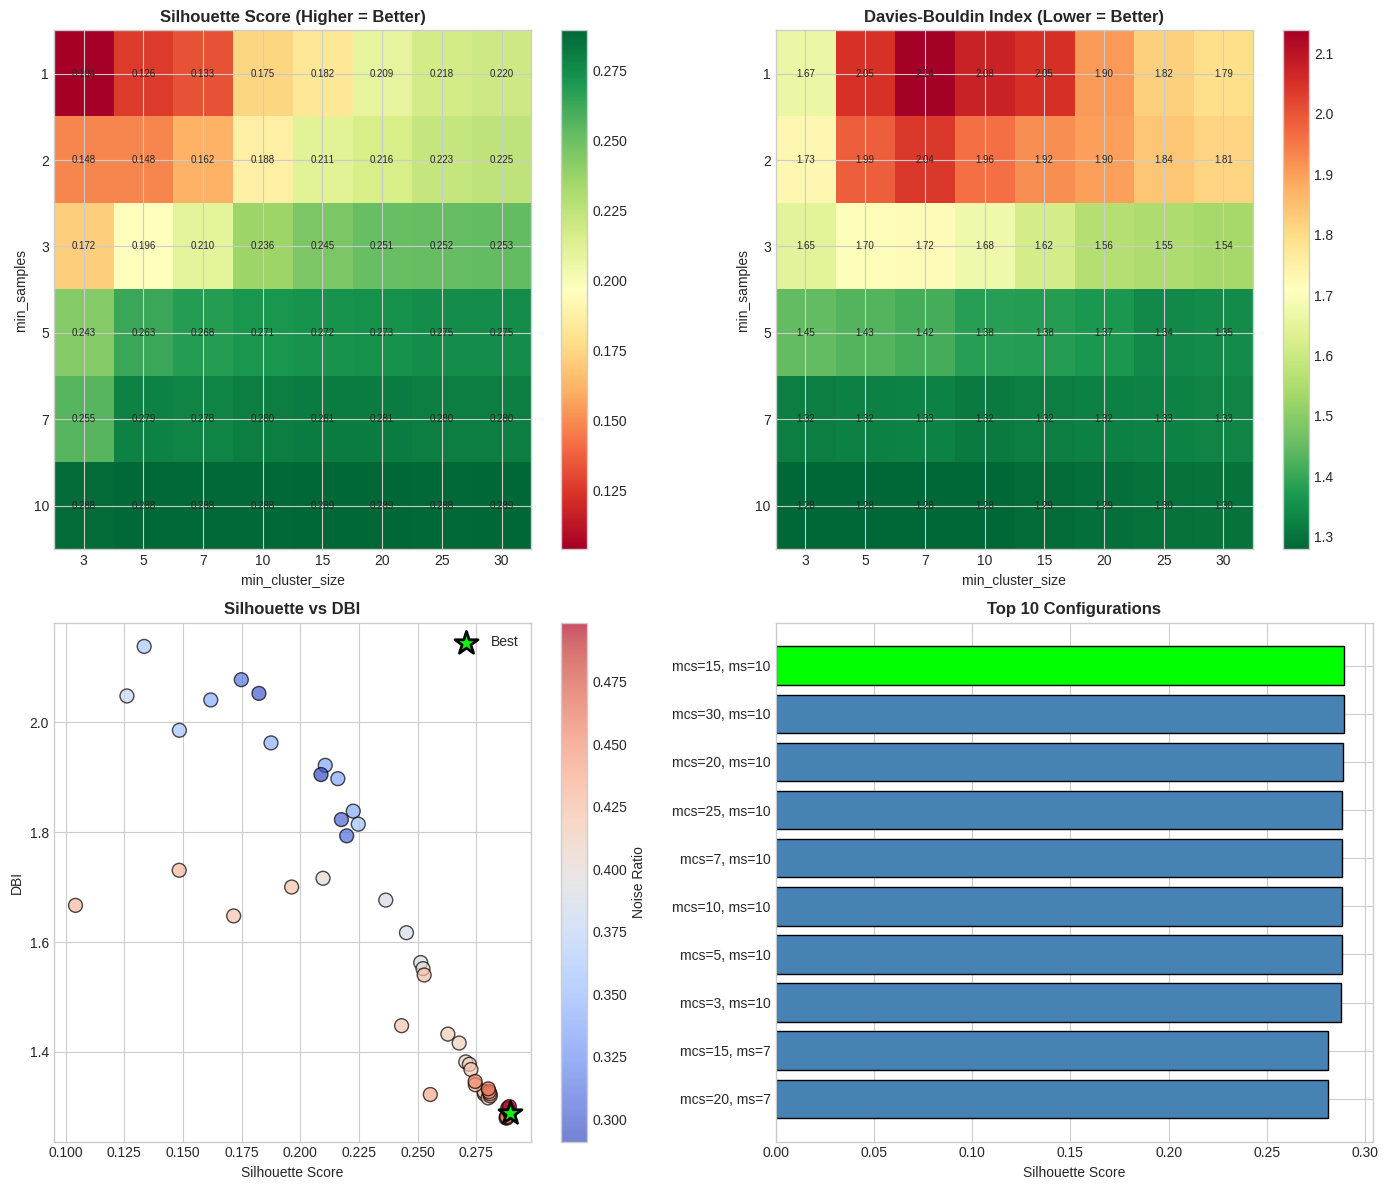


📊 CLUSTER ANALYSIS

📏 Cluster Size Statistics:
   • Total clusters: 86
   • Min: 16, Max: 1412
   • Mean: 78.8, Median: 62.0

🔍 Minority Clusters (≤10 samples):
   • Count: 0 / 86 (0.0%)


In [ ]:
"""
==============================================================================
🚀 RUN GRID SEARCH
==============================================================================
"""

print("="*70)
print("🚀 STEP 3: HYPERPARAMETER TUNING")
print("="*70)
print(f"\n📊 Dataset: {embeddings.shape[0]:,} embeddings × {embeddings.shape[1]} dimensions")
print(f"🖥️ Device: GPU (RAPIDS cuML)")

# Run grid search
results = run_grid_search(embeddings_gpu, embeddings, Config.GRID_SEARCH)

# Analyze
best_result, valid_results = analyze_results(results)

# Visualize
visualize_results(results, best_result,
                  save_path=f"{Config.PLOTS_DIR}hyperparameter_tuning.png")

# Cluster analysis
minority_clusters, valid_clusters = analyze_clusters(best_result, Config.MINORITY_THRESHOLD)

In [ ]:
"""
==============================================================================
📋 FINAL SUMMARY & SAVE
==============================================================================
"""

sizes = list(valid_clusters.values())

print("\n" + "="*70)
print("📋 STEP 3 FINAL SUMMARY")
print("="*70)

print(f"""
┌────────────────────────────────────────────────────────────────────┐
│              HYPERPARAMETER TUNING COMPLETE                        │
├────────────────────────────────────────────────────────────────────┤
│                                                                    │
│  🏆 OPTIMAL PARAMETERS:                                            │
│     min_cluster_size : {best_result['min_cluster_size']:<10}                               │
│     min_samples      : {best_result['min_samples']:<10}                               │
│                                                                    │
│  📊 RESULTS:                                                       │
│     Clusters         : {best_result['n_clusters']:<10}                                 │
│     Noise            : {best_result['noise_ratio']:.1%} ({best_result['n_noise']:,} points)                        │
│     Silhouette       : {best_result['silhouette']:.4f}                                   │
│     DBI              : {best_result['dbi']:.4f}                                   │
│                                                                    │
│  📏 CLUSTER SIZES:                                                 │
│     Min: {min(sizes)}, Max: {max(sizes)}, Mean: {np.mean(sizes):.1f}, Median: {np.median(sizes):.1f}              │
│                                                                    │
│  🔍 MINORITY CLUSTERS (≤{Config.MINORITY_THRESHOLD}): {len(minority_clusters)} clusters                      │
│     → Candidates for CGA augmentation                              │
│                                                                    │
└────────────────────────────────────────────────────────────────────┘
""")

# Save results
save_data = {
    'best_params': {
        'min_cluster_size': best_result['min_cluster_size'],
        'min_samples': best_result['min_samples'],
        'metric': 'euclidean'
    },
    'best_result': best_result,
    'all_results': results,
    'minority_clusters': minority_clusters,
    'valid_clusters': valid_clusters,
}

save_path = f"{Config.RESULTS_DIR}phase1_euclidean_results.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(save_data, f)
print(f"💾 Results saved: {save_path}")

# Next Steps
print("\n" + "="*70)
print("🎯 NEXT STEPS")
print("="*70)
print(f"""
   Silhouette Score: {best_result['silhouette']:.4f}

   Options:
   1. Try QJSD metric (Experiment 1 comparison)
   2. Proceed to CGA augmentation (Experiment 2)

   Minority clusters ({len(minority_clusters)}) will benefit from CGA!
""")


📋 STEP 3 FINAL SUMMARY

┌────────────────────────────────────────────────────────────────────┐
│              HYPERPARAMETER TUNING COMPLETE                        │
├────────────────────────────────────────────────────────────────────┤
│                                                                    │
│  🏆 OPTIMAL PARAMETERS:                                            │
│     min_cluster_size : 15                                       │
│     min_samples      : 10                                       │
│                                                                    │
│  📊 RESULTS:                                                       │
│     Clusters         : 86                                         │
│     Noise            : 46.7% (5,938 points)                        │
│     Silhouette       : 0.2893                                   │
│     DBI              : 1.2894                                   │
│                                                                  

# **EXTENDED HYPERPARAMETER TUNING**

🚀 STARTING EXTENDED HYPERPARAMETER TUNING

📊 Dataset: 12,715 embeddings × 512 dimensions
🚀 EXTENDED HYPERPARAMETER TUNING

📋 Extended Parameter Grid:
   • min_cluster_size: [3, 5, 7, 10, 12, 15, 18, 20, 25, 30, 40, 50] (12 values)
   • min_samples: [1, 2, 3, 5, 7, 10, 15, 20] (8 values)
   • cluster_selection_method: ['eom', 'leaf']
   • cluster_selection_epsilon: [0.0, 0.1, 0.5]
   • Total combinations: 576

   ⏱️ Estimated time: ~9.6 - 28.8 minutes

#     mcs   ms    method eps   Clusters  Noise%   Silhouette  DBI        Time  
--------------------------------------------------------------------------------
10    3     2     leaf   0.0   612       65.9%    0.1544      1.5804     0.95  s 
20    3     5     eom    0.1   132       42.0%    0.2432      1.4479     1.45  s 
30    3     7     leaf   0.5   152       58.9%    0.2414      1.3993     1.15  s 
40    3     15    leaf   0.0   104       51.7%    0.2870      1.2999     1.61  s 
50    5     1     eom    0.1   342       37.8%    0.126

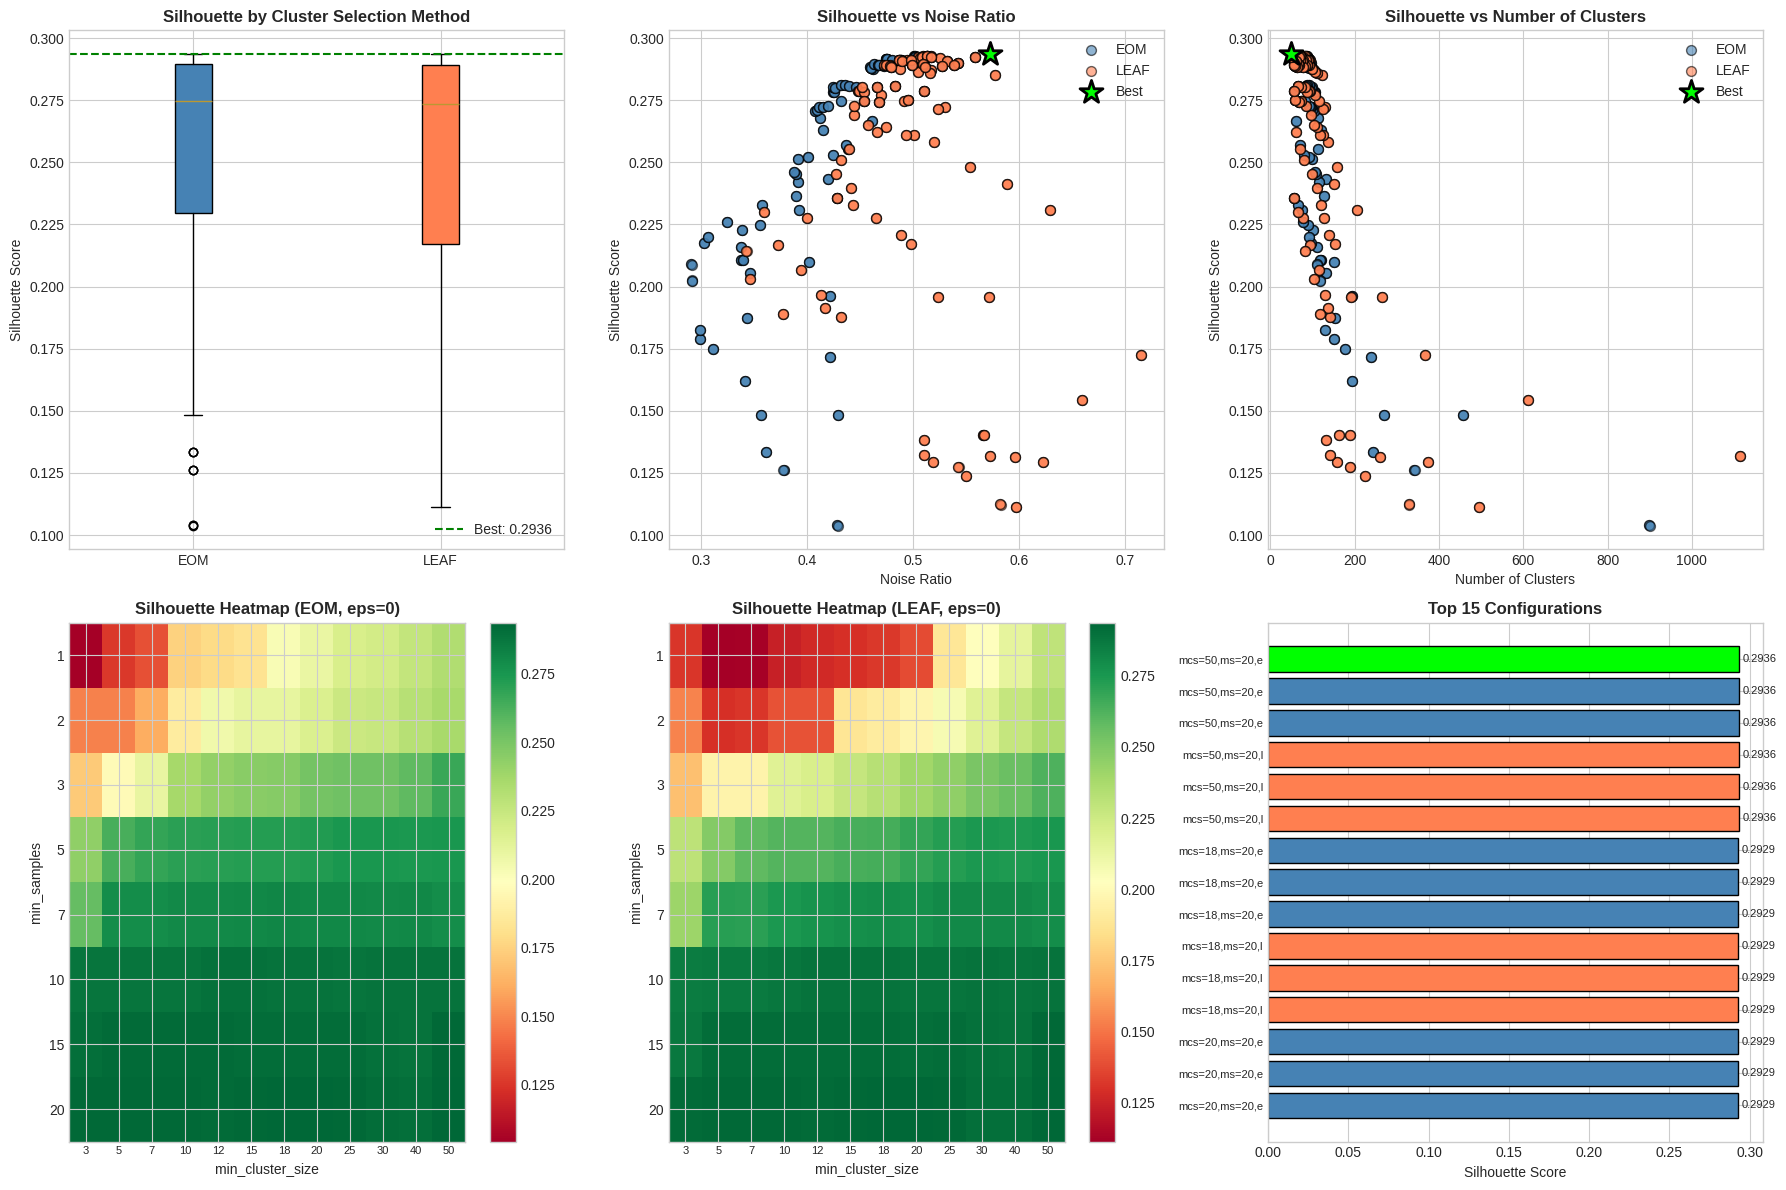

In [ ]:
"""
==============================================================================
EXTENDED HYPERPARAMETER TUNING
==============================================================================
Grid search lebih ekstensif dengan parameter tambahan:
1. min_cluster_size - range lebih luas dan granular
2. min_samples - range lebih luas
3. cluster_selection_method - 'eom' vs 'leaf'
4. cluster_selection_epsilon - untuk merge nearby clusters
==============================================================================
"""

def run_extended_grid_search(embeddings_gpu, embeddings_cpu):
    """
    Extended grid search dengan lebih banyak parameter.
    """

    print("="*70)
    print("🚀 EXTENDED HYPERPARAMETER TUNING")
    print("="*70)

    # Extended parameter grid
    param_grid = {
        'min_cluster_size': [3, 5, 7, 10, 12, 15, 18, 20, 25, 30, 40, 50],
        'min_samples': [1, 2, 3, 5, 7, 10, 15, 20],
        'cluster_selection_method': ['eom', 'leaf'],
        'cluster_selection_epsilon': [0.0, 0.1, 0.5]
    }

    total_mcs = len(param_grid['min_cluster_size'])
    total_ms = len(param_grid['min_samples'])
    total_method = len(param_grid['cluster_selection_method'])
    total_epsilon = len(param_grid['cluster_selection_epsilon'])
    total = total_mcs * total_ms * total_method * total_epsilon

    print(f"\n📋 Extended Parameter Grid:")
    print(f"   • min_cluster_size: {param_grid['min_cluster_size']} ({total_mcs} values)")
    print(f"   • min_samples: {param_grid['min_samples']} ({total_ms} values)")
    print(f"   • cluster_selection_method: {param_grid['cluster_selection_method']}")
    print(f"   • cluster_selection_epsilon: {param_grid['cluster_selection_epsilon']}")
    print(f"   • Total combinations: {total}")
    print(f"\n   ⏱️ Estimated time: ~{total * 1 / 60:.1f} - {total * 3 / 60:.1f} minutes")

    results = []
    start_time = time.time()

    # Header
    print(f"\n{'#':<5} {'mcs':<5} {'ms':<5} {'method':<6} {'eps':<5} {'Clusters':<9} {'Noise%':<8} {'Silhouette':<11} {'DBI':<10} {'Time':<6}")
    print("-"*80)

    iteration = 0
    for mcs in param_grid['min_cluster_size']:
        for ms in param_grid['min_samples']:
            for method in param_grid['cluster_selection_method']:
                for eps in param_grid['cluster_selection_epsilon']:
                    iteration += 1
                    iter_start = time.time()

                    try:
                        # Run GPU HDBSCAN dengan parameter extended
                        clusterer = cuHDBSCAN(
                            min_cluster_size=mcs,
                            min_samples=ms,
                            cluster_selection_method=method,
                            cluster_selection_epsilon=eps,
                            metric='euclidean',
                            output_type='numpy'
                        )
                        labels = clusterer.fit_predict(embeddings_gpu)

                        # Ensure numpy array
                        if isinstance(labels, cp.ndarray):
                            labels = cp.asnumpy(labels)

                        # Analyze
                        cluster_counts = Counter(labels)
                        n_clusters = len([k for k in cluster_counts.keys() if k != -1])
                        n_noise = cluster_counts.get(-1, 0)
                        noise_ratio = n_noise / len(labels)

                        # Evaluate
                        mask = labels != -1
                        if mask.sum() > 0 and len(np.unique(labels[mask])) >= 2:
                            silhouette = silhouette_score(embeddings_cpu[mask], labels[mask])
                            dbi = davies_bouldin_score(embeddings_cpu[mask], labels[mask])
                        else:
                            silhouette = -1.0
                            dbi = float('inf')

                    except Exception as e:
                        n_clusters = 0
                        n_noise = len(embeddings_cpu)
                        noise_ratio = 1.0
                        silhouette = -1.0
                        dbi = float('inf')
                        labels = np.array([-1] * len(embeddings_cpu))
                        cluster_counts = Counter(labels)

                    iter_time = time.time() - iter_start

                    # Store
                    results.append({
                        'min_cluster_size': mcs,
                        'min_samples': ms,
                        'cluster_selection_method': method,
                        'cluster_selection_epsilon': eps,
                        'n_clusters': n_clusters,
                        'n_noise': n_noise,
                        'noise_ratio': noise_ratio,
                        'silhouette': silhouette,
                        'dbi': dbi,
                        'labels': labels,
                        'cluster_counts': cluster_counts,
                        'runtime': iter_time
                    })

                    # Print progress (every 10 iterations to reduce output)
                    if iteration % 10 == 0 or silhouette > 0.30:
                        method_short = 'eom' if method == 'eom' else 'leaf'
                        marker = "⭐" if silhouette > 0.30 else ""
                        print(f"{iteration:<5} {mcs:<5} {ms:<5} {method_short:<6} {eps:<5} {n_clusters:<9} {noise_ratio:<8.1%} {silhouette:<11.4f} {dbi:<10.4f} {iter_time:<6.2f}s {marker}")

    total_time = time.time() - start_time
    print("-"*80)
    print(f"\n✅ Extended grid search completed in {total_time:.2f}s ({total_time/60:.2f} min)")

    return results, param_grid


def analyze_extended_results(results):
    """
    Analyze extended grid search results.
    """

    print(f"\n{'='*70}")
    print("📊 ANALYZING EXTENDED RESULTS")
    print(f"{'='*70}")

    # Filter valid
    valid_results = [r for r in results if r['silhouette'] > -1]
    print(f"\n   Valid configurations: {len(valid_results)}/{len(results)}")

    if not valid_results:
        print("   ❌ No valid results!")
        return None

    # Sort by silhouette
    sorted_by_sil = sorted(valid_results, key=lambda x: x['silhouette'], reverse=True)

    # Top 10 by Silhouette
    print(f"\n🏆 TOP 10 BY SILHOUETTE SCORE:")
    print(f"   {'#':<4} {'mcs':<5} {'ms':<5} {'method':<6} {'eps':<5} {'Clusters':<9} {'Noise%':<8} {'Silhouette':<11} {'DBI':<10}")
    print("   " + "-"*70)

    for i, r in enumerate(sorted_by_sil[:10]):
        method_short = 'eom' if r['cluster_selection_method'] == 'eom' else 'leaf'
        print(f"   {i+1:<4} {r['min_cluster_size']:<5} {r['min_samples']:<5} {method_short:<6} {r['cluster_selection_epsilon']:<5} {r['n_clusters']:<9} {r['noise_ratio']:<8.1%} {r['silhouette']:<11.4f} {r['dbi']:<10.4f}")

    # Best overall
    best = sorted_by_sil[0]

    print(f"\n🥇 BEST CONFIGURATION:")
    print(f"   ┌─────────────────────────────────────────────────")
    print(f"   │ min_cluster_size        : {best['min_cluster_size']}")
    print(f"   │ min_samples             : {best['min_samples']}")
    print(f"   │ cluster_selection_method: {best['cluster_selection_method']}")
    print(f"   │ cluster_selection_epsilon: {best['cluster_selection_epsilon']}")
    print(f"   ├──────────────────────────────────────────────���──")
    print(f"   │ Clusters    : {best['n_clusters']}")
    print(f"   │ Noise       : {best['noise_ratio']:.1%} ({best['n_noise']:,} points)")
    print(f"   │ Silhouette  : {best['silhouette']:.4f}")
    print(f"   │ DBI         : {best['dbi']:.4f}")
    print(f"   └─────────────────────────────────────────────────")

    # Compare methods
    print(f"\n📊 COMPARISON BY METHOD:")
    for method in ['eom', 'leaf']:
        method_results = [r for r in valid_results if r['cluster_selection_method'] == method]
        if method_results:
            best_method = max(method_results, key=lambda x: x['silhouette'])
            avg_sil = np.mean([r['silhouette'] for r in method_results])
            print(f"   • {method.upper()}: Best Sil={best_method['silhouette']:.4f}, Avg Sil={avg_sil:.4f} (n={len(method_results)})")

    return best, sorted_by_sil


def visualize_extended_results(results, best_result, save_path=None):
    """
    Visualize extended grid search results.
    """

    print(f"\n{'='*70}")
    print("📊 GENERATING VISUALIZATIONS")
    print(f"{'='*70}")

    valid_results = [r for r in results if r['silhouette'] > -1]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # --------------------------------------------------------------------------
    # Plot 1: Silhouette by method (boxplot)
    # --------------------------------------------------------------------------
    ax1 = axes[0, 0]
    eom_sils = [r['silhouette'] for r in valid_results if r['cluster_selection_method'] == 'eom']
    leaf_sils = [r['silhouette'] for r in valid_results if r['cluster_selection_method'] == 'leaf']

    bp = ax1.boxplot([eom_sils, leaf_sils], labels=['EOM', 'LEAF'], patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][1].set_facecolor('coral')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette by Cluster Selection Method', fontweight='bold')
    ax1.axhline(y=best_result['silhouette'], color='green', linestyle='--', label=f"Best: {best_result['silhouette']:.4f}")
    ax1.legend()

    # --------------------------------------------------------------------------
    # Plot 2: Silhouette vs Noise Ratio (scatter, colored by method)
    # --------------------------------------------------------------------------
    ax2 = axes[0, 1]
    for method, color in [('eom', 'steelblue'), ('leaf', 'coral')]:
        method_results = [r for r in valid_results if r['cluster_selection_method'] == method]
        sils = [r['silhouette'] for r in method_results]
        noises = [r['noise_ratio'] for r in method_results]
        ax2.scatter(noises, sils, c=color, alpha=0.6, label=method.upper(), edgecolors='black', s=50)

    ax2.scatter(best_result['noise_ratio'], best_result['silhouette'],
               color='lime', s=300, marker='*', edgecolors='black', linewidths=2,
               zorder=5, label='Best')
    ax2.set_xlabel('Noise Ratio')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette vs Noise Ratio', fontweight='bold')
    ax2.legend()

    # --------------------------------------------------------------------------
    # Plot 3: Silhouette vs Number of Clusters
    # --------------------------------------------------------------------------
    ax3 = axes[0, 2]
    for method, color in [('eom', 'steelblue'), ('leaf', 'coral')]:
        method_results = [r for r in valid_results if r['cluster_selection_method'] == method]
        sils = [r['silhouette'] for r in method_results]
        clusters = [r['n_clusters'] for r in method_results]
        ax3.scatter(clusters, sils, c=color, alpha=0.6, label=method.upper(), edgecolors='black', s=50)

    ax3.scatter(best_result['n_clusters'], best_result['silhouette'],
               color='lime', s=300, marker='*', edgecolors='black', linewidths=2,
               zorder=5, label='Best')
    ax3.set_xlabel('Number of Clusters')
    ax3.set_ylabel('Silhouette Score')
    ax3.set_title('Silhouette vs Number of Clusters', fontweight='bold')
    ax3.legend()

    # --------------------------------------------------------------------------
    # Plot 4: Heatmap for EOM (mcs vs ms)
    # --------------------------------------------------------------------------
    ax4 = axes[1, 0]
    eom_results = [r for r in valid_results if r['cluster_selection_method'] == 'eom' and r['cluster_selection_epsilon'] == 0.0]

    mcs_vals = sorted(set(r['min_cluster_size'] for r in eom_results))
    ms_vals = sorted(set(r['min_samples'] for r in eom_results))

    heatmap_eom = np.full((len(ms_vals), len(mcs_vals)), np.nan)
    for r in eom_results:
        if r['min_cluster_size'] in mcs_vals and r['min_samples'] in ms_vals:
            i = ms_vals.index(r['min_samples'])
            j = mcs_vals.index(r['min_cluster_size'])
            heatmap_eom[i, j] = r['silhouette']

    im4 = ax4.imshow(heatmap_eom, cmap='RdYlGn', aspect='auto')
    ax4.set_xticks(range(len(mcs_vals)))
    ax4.set_xticklabels(mcs_vals, fontsize=8)
    ax4.set_yticks(range(len(ms_vals)))
    ax4.set_yticklabels(ms_vals)
    ax4.set_xlabel('min_cluster_size')
    ax4.set_ylabel('min_samples')
    ax4.set_title('Silhouette Heatmap (EOM, eps=0)', fontweight='bold')
    plt.colorbar(im4, ax=ax4)

    # --------------------------------------------------------------------------
    # Plot 5: Heatmap for LEAF (mcs vs ms)
    # --------------------------------------------------------------------------
    ax5 = axes[1, 1]
    leaf_results = [r for r in valid_results if r['cluster_selection_method'] == 'leaf' and r['cluster_selection_epsilon'] == 0.0]

    mcs_vals_leaf = sorted(set(r['min_cluster_size'] for r in leaf_results))
    ms_vals_leaf = sorted(set(r['min_samples'] for r in leaf_results))

    heatmap_leaf = np.full((len(ms_vals_leaf), len(mcs_vals_leaf)), np.nan)
    for r in leaf_results:
        if r['min_cluster_size'] in mcs_vals_leaf and r['min_samples'] in ms_vals_leaf:
            i = ms_vals_leaf.index(r['min_samples'])
            j = mcs_vals_leaf.index(r['min_cluster_size'])
            heatmap_leaf[i, j] = r['silhouette']

    im5 = ax5.imshow(heatmap_leaf, cmap='RdYlGn', aspect='auto')
    ax5.set_xticks(range(len(mcs_vals_leaf)))
    ax5.set_xticklabels(mcs_vals_leaf, fontsize=8)
    ax5.set_yticks(range(len(ms_vals_leaf)))
    ax5.set_yticklabels(ms_vals_leaf)
    ax5.set_xlabel('min_cluster_size')
    ax5.set_ylabel('min_samples')
    ax5.set_title('Silhouette Heatmap (LEAF, eps=0)', fontweight='bold')
    plt.colorbar(im5, ax=ax5)

    # --------------------------------------------------------------------------
    # Plot 6: Top 15 configurations (bar chart)
    # --------------------------------------------------------------------------
    ax6 = axes[1, 2]
    sorted_results = sorted(valid_results, key=lambda x: x['silhouette'], reverse=True)[:15]

    labels_plot = [f"mcs={r['min_cluster_size']},ms={r['min_samples']},{r['cluster_selection_method'][:1]}"
                   for r in sorted_results]
    sils_plot = [r['silhouette'] for r in sorted_results]
    colors = ['lime' if r == best_result else ('steelblue' if r['cluster_selection_method'] == 'eom' else 'coral')
              for r in sorted_results]

    bars = ax6.barh(range(len(labels_plot)), sils_plot, color=colors, edgecolor='black')
    ax6.set_yticks(range(len(labels_plot)))
    ax6.set_yticklabels(labels_plot, fontsize=8)
    ax6.set_xlabel('Silhouette Score')
    ax6.set_title('Top 15 Configurations', fontweight='bold')
    ax6.invert_yaxis()

    # Add value labels
    for bar, val in zip(bars, sils_plot):
        ax6.text(val + 0.002, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=8)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n💾 Plot saved: {save_path}")

    plt.show()


# ==============================================================================
# RUN EXTENDED GRID SEARCH
# ==============================================================================

print("="*70)
print("🚀 STARTING EXTENDED HYPERPARAMETER TUNING")
print("="*70)
print(f"\n📊 Dataset: {embeddings.shape[0]:,} embeddings × {embeddings.shape[1]} dimensions")

# Run extended grid search
extended_results, param_grid = run_extended_grid_search(embeddings_gpu, embeddings)

# Analyze results
best_extended, sorted_results = analyze_extended_results(extended_results)

# Visualize
visualize_extended_results(
    extended_results,
    best_extended,
    save_path=f"{Config.PLOTS_DIR}extended_hyperparameter_tuning.png"
)

In [ ]:
"""
==============================================================================
📋 EXTENDED TUNING SUMMARY & COMPARISON
==============================================================================
"""

# Get cluster info from best result
cluster_counts = best_extended['cluster_counts']
valid_clusters = {k: v for k, v in cluster_counts.items() if k != -1}
sizes = list(valid_clusters.values()) if valid_clusters else [0]
minority_clusters = {k: v for k, v in valid_clusters.items() if v <= Config.MINORITY_THRESHOLD}

print("\n" + "="*70)
print("📋 EXTENDED TUNING FINAL SUMMARY")
print("="*70)

# Previous vs New comparison
print(f"""
┌────────────────────────────────────────────────────────────────────┐
│              COMPARISON: PREVIOUS vs EXTENDED TUNING               │
├────────────────────────────────────────────────────────────────────┤
│                                                                    │
│                          PREVIOUS         EXTENDED                 │
│  ────────────────────────────────────────────────────────────      │
│  min_cluster_size      :    15              {best_extended['min_cluster_size']:<10}            │
│  min_samples           :    10              {best_extended['min_samples']:<10}            │
│  selection_method      :    eom             {best_extended['cluster_selection_method']:<10}            │
│  selection_epsilon     :    0.0             {best_extended['cluster_selection_epsilon']:<10}            │
│  ────────────────────────────────────────────────────────────      │
│  Clusters              :    86              {best_extended['n_clusters']:<10}            │
│  Noise                 :   46.7%            {best_extended['noise_ratio']:.1%}                       │
│  Silhouette            :   0.2893           {best_extended['silhouette']:.4f}                     │
│  DBI                   :   1.2894           {best_extended['dbi']:.4f}                     │
│  ────────────────────────────────────────────────────────────      │
│  Cluster Size Min      :    16              {min(sizes) if sizes else 'N/A':<10}            │
│  Cluster Size Max      :   1412             {max(sizes) if sizes else 'N/A':<10}            │
│  Minority Clusters     :     0              {len(minority_clusters):<10}            │
│                                                                    │
└────────────────────────────────��───────────────────────────────────┘
""")

# Improvement calculation
prev_sil = 0.2893
new_sil = best_extended['silhouette']
improvement = ((new_sil - prev_sil) / prev_sil) * 100

if new_sil > prev_sil:
    print(f"   ✅ IMPROVEMENT: Silhouette {prev_sil:.4f} → {new_sil:.4f} (+{improvement:.1f}%)")
elif new_sil < prev_sil:
    print(f"   ❌ WORSE: Silhouette {prev_sil:.4f} → {new_sil:.4f} ({improvement:.1f}%)")
else:
    print(f"   ➖ SAME: Silhouette unchanged at {new_sil:.4f}")

# Save extended results
save_data = {
    'best_params': {
        'min_cluster_size': best_extended['min_cluster_size'],
        'min_samples': best_extended['min_samples'],
        'cluster_selection_method': best_extended['cluster_selection_method'],
        'cluster_selection_epsilon': best_extended['cluster_selection_epsilon'],
        'metric': 'euclidean'
    },
    'best_result': best_extended,
    'all_results': extended_results,
    'sorted_results': sorted_results,
    'minority_clusters': minority_clusters,
    'valid_clusters': valid_clusters,
    'comparison': {
        'previous_silhouette': 0.2893,
        'new_silhouette': best_extended['silhouette'],
        'improvement_pct': improvement
    }
}

save_path = f"{Config.RESULTS_DIR}phase1_euclidean_extended_results.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(save_data, f)
print(f"\n💾 Results saved: {save_path}")

print("\n" + "="*70)
print("🎯 NEXT STEPS")
print("="*70)
print(f"""
   Best Silhouette achieved: {best_extended['silhouette']:.4f}

   Options:
   1. If satisfied → Proceed to QJSD comparison or CGA
   2. If not satisfied → Try even more parameter combinations
   3. Consider that Silhouette ~0.3 might be the ceiling for this dataset

   Note: Face embeddings often have complex cluster structures
   that don't always produce high Silhouette scores.
""")


📋 EXTENDED TUNING FINAL SUMMARY

┌────────────────────────────────────────────────────────────────────┐
│              COMPARISON: PREVIOUS vs EXTENDED TUNING               │
├────────────────────────────────────────────────────────────────────┤
│                                                                    │
│                          PREVIOUS         EXTENDED                 │
│  ────────────────────────────────────────────────────────────      │
│  min_cluster_size      :    15              50                    │
│  min_samples           :    10              20                    │
│  selection_method      :    eom             eom                   │
│  selection_epsilon     :    0.0             0.0                   │
│  ────────────────────────────────────────────────────────────      │
│  Clusters              :    86              48                    │
│  Noise                 :   46.7%            57.3%                       │
│  Silhouette            :   0.2893        

# **ULTRA-EXTENDED HYPERPARAMETER TUNING**

🚀 STARTING ULTRA-EXTENDED HYPERPARAMETER TUNING

📊 Dataset: 12,715 embeddings × 512 dimensions
🏆 Previous best Silhouette: 0.2936
🎯 Goal: Beat 0.2936!
🚀 ULTRA-EXTENDED HYPERPARAMETER TUNING

📋 Ultra-Extended Parameter Grid:
   • min_cluster_size: [20, 30, 40, 50, 60, 75, 100, 125, 150, 200] (10 values)
   • min_samples: [5, 10, 15, 20, 25, 30, 40, 50] (8 values)
   • cluster_selection_method: ['eom', 'leaf']
   • cluster_selection_epsilon: [0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
   • Total combinations: 1120

   ⏱️ Estimated time: ~19 - 37 minutes with GPU

#     mcs   ms    meth  eps   Clust   Noise%   Silhou    DBI       Best? 
---------------------------------------------------------------------------
1     20    5     eom   0.00  91      42.0%    0.2728    1.3681    ⭐NEW!
15    20    10    eom   0.00  82      47.3%    0.2887    1.2947    ⭐NEW!
29    20    15    eom   0.00  76      49.0%    0.2907    1.2908    ⭐NEW!
43    20    20    eom   0.00  70      51.3%    0.2929    1.2912    ⭐NE

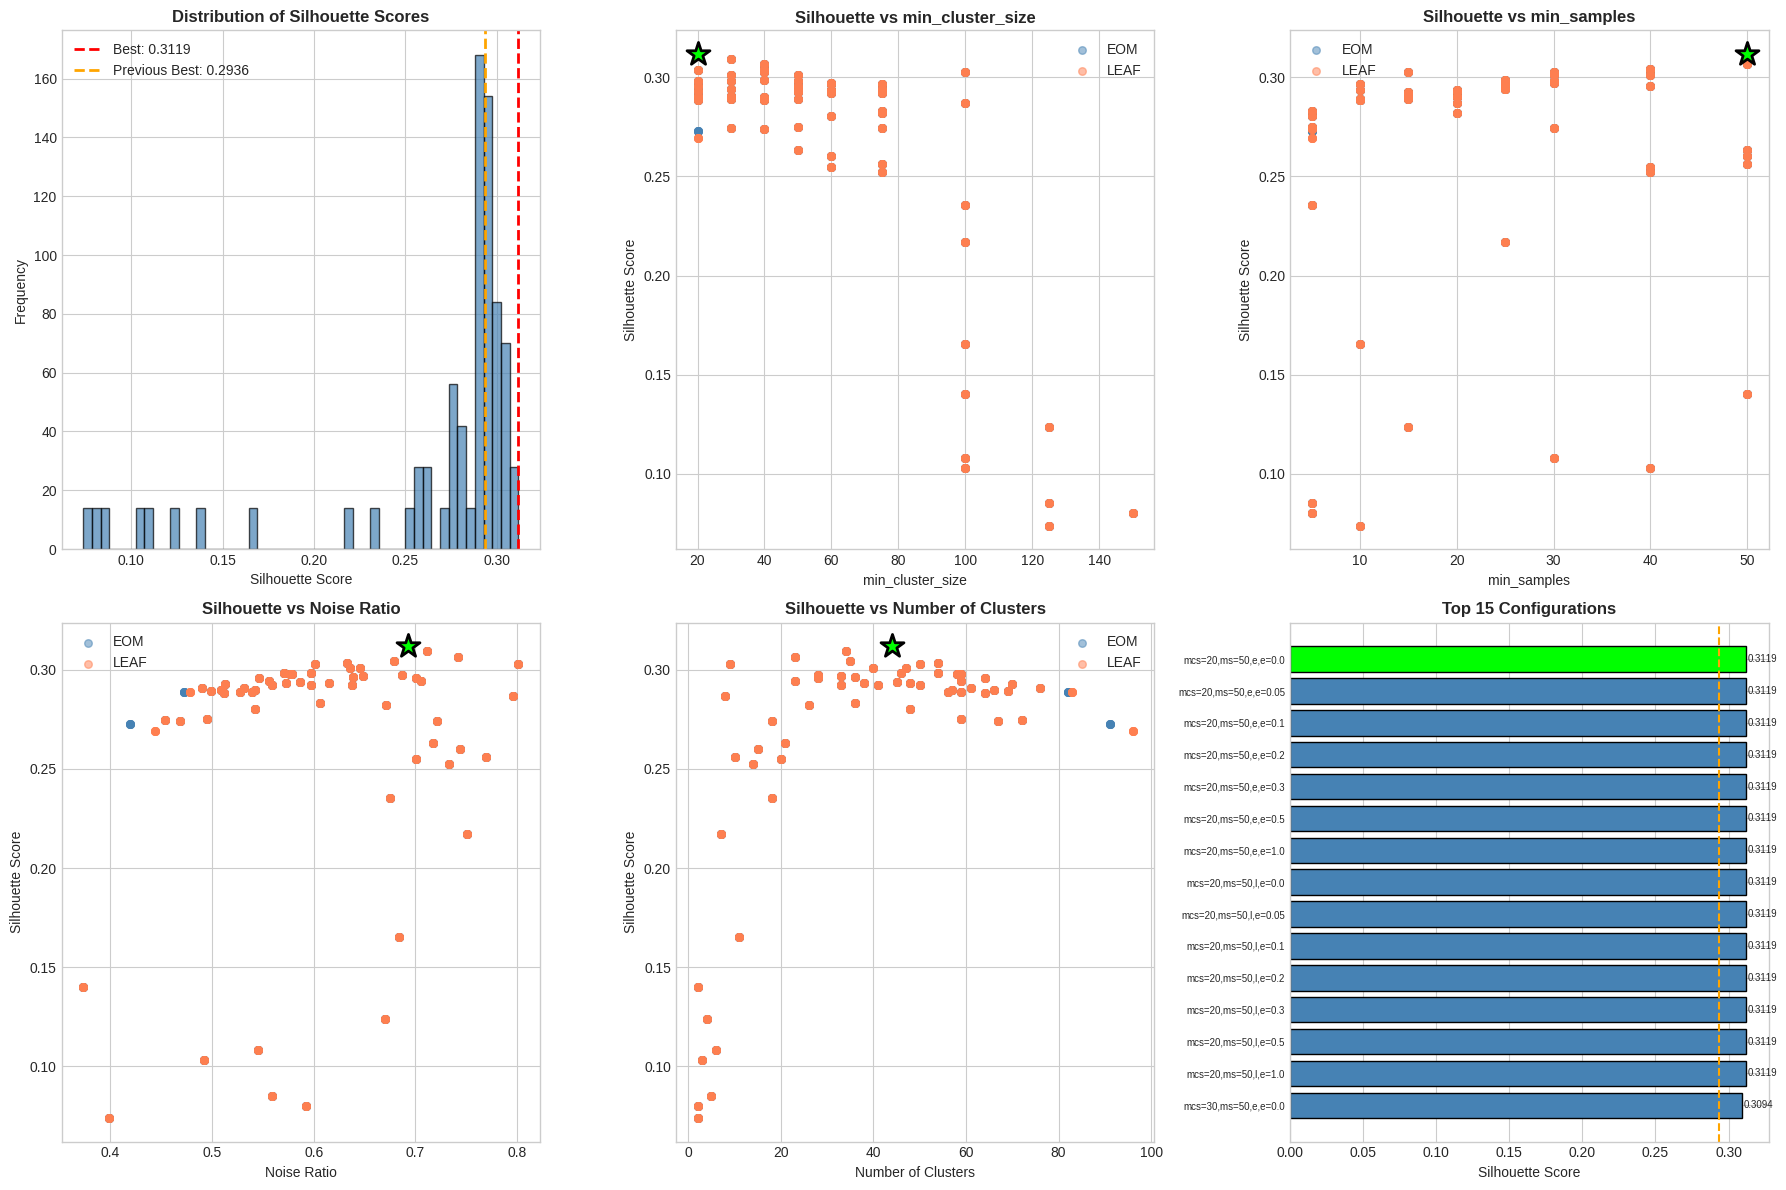

In [ ]:
"""
==============================================================================
ULTRA-EXTENDED HYPERPARAMETER TUNING
==============================================================================
Mencoba range parameter yang lebih luas, terutama nilai-nilai besar
yang menunjukkan trend positif dari hasil sebelumnya.
==============================================================================
"""

def run_ultra_extended_grid_search(embeddings_gpu, embeddings_cpu):
    """
    Ultra-extended grid search dengan focus pada:
    1. min_cluster_size yang lebih besar (trend menunjukkan nilai besar lebih baik)
    2. min_samples yang lebih besar
    3. Kombinasi dengan 'leaf' method
    4. Berbagai nilai epsilon
    """

    print("="*70)
    print("🚀 ULTRA-EXTENDED HYPERPARAMETER TUNING")
    print("="*70)

    # Ultra-extended parameter grid
    param_grid = {
        # Focus pada nilai lebih besar berdasarkan trend sebelumnya
        'min_cluster_size': [20, 30, 40, 50, 60, 75, 100, 125, 150, 200],
        'min_samples': [5, 10, 15, 20, 25, 30, 40, 50],
        'cluster_selection_method': ['eom', 'leaf'],
        'cluster_selection_epsilon': [0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
    }

    total = (len(param_grid['min_cluster_size']) *
             len(param_grid['min_samples']) *
             len(param_grid['cluster_selection_method']) *
             len(param_grid['cluster_selection_epsilon']))

    print(f"\n📋 Ultra-Extended Parameter Grid:")
    print(f"   • min_cluster_size: {param_grid['min_cluster_size']} ({len(param_grid['min_cluster_size'])} values)")
    print(f"   • min_samples: {param_grid['min_samples']} ({len(param_grid['min_samples'])} values)")
    print(f"   • cluster_selection_method: {param_grid['cluster_selection_method']}")
    print(f"   • cluster_selection_epsilon: {param_grid['cluster_selection_epsilon']}")
    print(f"   • Total combinations: {total}")
    print(f"\n   ⏱️ Estimated time: ~{total * 1 / 60:.0f} - {total * 2 / 60:.0f} minutes with GPU")

    results = []
    start_time = time.time()
    best_so_far = {'silhouette': 0}

    # Header
    print(f"\n{'#':<5} {'mcs':<5} {'ms':<5} {'meth':<5} {'eps':<5} {'Clust':<7} {'Noise%':<8} {'Silhou':<9} {'DBI':<9} {'Best?':<6}")
    print("-"*75)

    iteration = 0
    for mcs in param_grid['min_cluster_size']:
        for ms in param_grid['min_samples']:
            for method in param_grid['cluster_selection_method']:
                for eps in param_grid['cluster_selection_epsilon']:
                    iteration += 1
                    iter_start = time.time()

                    try:
                        # Run GPU HDBSCAN
                        clusterer = cuHDBSCAN(
                            min_cluster_size=mcs,
                            min_samples=ms,
                            cluster_selection_method=method,
                            cluster_selection_epsilon=eps,
                            metric='euclidean',
                            output_type='numpy'
                        )
                        labels = clusterer.fit_predict(embeddings_gpu)

                        if isinstance(labels, cp.ndarray):
                            labels = cp.asnumpy(labels)

                        # Analyze
                        cluster_counts = Counter(labels)
                        n_clusters = len([k for k in cluster_counts.keys() if k != -1])
                        n_noise = cluster_counts.get(-1, 0)
                        noise_ratio = n_noise / len(labels)

                        # Evaluate
                        mask = labels != -1
                        if mask.sum() > 0 and len(np.unique(labels[mask])) >= 2:
                            silhouette = silhouette_score(embeddings_cpu[mask], labels[mask])
                            dbi = davies_bouldin_score(embeddings_cpu[mask], labels[mask])
                        else:
                            silhouette = -1.0
                            dbi = float('inf')

                    except Exception as e:
                        n_clusters = 0
                        n_noise = len(embeddings_cpu)
                        noise_ratio = 1.0
                        silhouette = -1.0
                        dbi = float('inf')
                        labels = np.array([-1] * len(embeddings_cpu))
                        cluster_counts = Counter(labels)

                    iter_time = time.time() - iter_start

                    # Check if new best
                    is_new_best = silhouette > best_so_far['silhouette']
                    if is_new_best:
                        best_so_far = {
                            'silhouette': silhouette,
                            'mcs': mcs, 'ms': ms,
                            'method': method, 'eps': eps
                        }

                    # Store
                    results.append({
                        'min_cluster_size': mcs,
                        'min_samples': ms,
                        'cluster_selection_method': method,
                        'cluster_selection_epsilon': eps,
                        'n_clusters': n_clusters,
                        'n_noise': n_noise,
                        'noise_ratio': noise_ratio,
                        'silhouette': silhouette,
                        'dbi': dbi,
                        'labels': labels,
                        'cluster_counts': cluster_counts,
                        'runtime': iter_time
                    })

                    # Print progress (show new bests and every 50 iterations)
                    if is_new_best or iteration % 50 == 0:
                        m_short = 'eom' if method == 'eom' else 'lf'
                        best_marker = "⭐NEW!" if is_new_best else ""
                        print(f"{iteration:<5} {mcs:<5} {ms:<5} {m_short:<5} {eps:<5.2f} {n_clusters:<7} {noise_ratio:<8.1%} {silhouette:<9.4f} {dbi:<9.4f} {best_marker}")

    total_time = time.time() - start_time
    print("-"*75)
    print(f"\n✅ Ultra-extended search completed in {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"🏆 Best Silhouette found: {best_so_far['silhouette']:.4f}")

    return results, param_grid


def comprehensive_analysis(results, previous_best_sil=0.2936):
    """
    Comprehensive analysis of all results.
    """

    print(f"\n{'='*70}")
    print("📊 COMPREHENSIVE ANALYSIS")
    print(f"{'='*70}")

    # Filter valid
    valid_results = [r for r in results if r['silhouette'] > -1]
    print(f"\n   Valid configurations: {len(valid_results)}/{len(results)}")

    if not valid_results:
        print("   ❌ No valid results!")
        return None, None

    # Sort by silhouette
    sorted_by_sil = sorted(valid_results, key=lambda x: x['silhouette'], reverse=True)

    # -------------------------------------------------------------------------
    # TOP 20 Results
    # -------------------------------------------------------------------------
    print(f"\n🏆 TOP 20 CONFIGURATIONS BY SILHOUETTE:")
    print(f"   {'#':<4} {'mcs':<5} {'ms':<5} {'method':<6} {'eps':<5} {'Clusters':<9} {'Noise%':<8} {'Silhouette':<11} {'DBI':<10}")
    print("   " + "-"*75)

    for i, r in enumerate(sorted_by_sil[:20]):
        m_short = 'eom' if r['cluster_selection_method'] == 'eom' else 'leaf'
        improvement = "✅" if r['silhouette'] > previous_best_sil else ""
        print(f"   {i+1:<4} {r['min_cluster_size']:<5} {r['min_samples']:<5} {m_short:<6} {r['cluster_selection_epsilon']:<5.2f} {r['n_clusters']:<9} {r['noise_ratio']:<8.1%} {r['silhouette']:<11.4f} {r['dbi']:<10.4f} {improvement}")

    # -------------------------------------------------------------------------
    # Best Result
    # -------------------------------------------------------------------------
    best = sorted_by_sil[0]

    print(f"\n{'='*70}")
    print("🥇 ABSOLUTE BEST CONFIGURATION")
    print(f"{'='*70}")
    print(f"""
   ┌─────────────────────────────────────────────────────────────┐
   │  PARAMETERS:                                                │
   │    min_cluster_size         : {best['min_cluster_size']:<10}                     │
   │    min_samples              : {best['min_samples']:<10}                     │
   │    cluster_selection_method : {best['cluster_selection_method']:<10}                     │
   │    cluster_selection_epsilon: {best['cluster_selection_epsilon']:<10}                     │
   ├─────────────────────────────────────────────────────────────┤
   │  RESULTS:                                                   │
   │    Clusters       : {best['n_clusters']:<10}                              │
   │    Noise          : {best['noise_ratio']:.1%} ({best['n_noise']:,} points)                       │
   │    Silhouette     : {best['silhouette']:.4f}                                   │
   │    DBI            : {best['dbi']:.4f}                                   │
   └─────────────────────────────────────────────────────────────┘
    """)

    # -------------------------------------------------------------------------
    # Analysis by Parameter
    # -------------------------------------------------------------------------
    print(f"\n📊 ANALYSIS BY PARAMETER:")

    # By method
    print(f"\n   By cluster_selection_method:")
    for method in ['eom', 'leaf']:
        m_results = [r for r in valid_results if r['cluster_selection_method'] == method]
        if m_results:
            best_m = max(m_results, key=lambda x: x['silhouette'])
            avg_sil = np.mean([r['silhouette'] for r in m_results])
            print(f"      {method.upper()}: Best={best_m['silhouette']:.4f}, Avg={avg_sil:.4f}, Count={len(m_results)}")

    # By epsilon
    print(f"\n   By cluster_selection_epsilon:")
    for eps in sorted(set(r['cluster_selection_epsilon'] for r in valid_results)):
        e_results = [r for r in valid_results if r['cluster_selection_epsilon'] == eps]
        if e_results:
            best_e = max(e_results, key=lambda x: x['silhouette'])
            avg_sil = np.mean([r['silhouette'] for r in e_results])
            print(f"      eps={eps:.2f}: Best={best_e['silhouette']:.4f}, Avg={avg_sil:.4f}, Count={len(e_results)}")

    # By min_cluster_size (top 5 values)
    print(f"\n   By min_cluster_size (best silhouette for each):")
    mcs_best = {}
    for r in valid_results:
        mcs = r['min_cluster_size']
        if mcs not in mcs_best or r['silhouette'] > mcs_best[mcs]['silhouette']:
            mcs_best[mcs] = r

    for mcs in sorted(mcs_best.keys()):
        r = mcs_best[mcs]
        print(f"      mcs={mcs:<4}: Sil={r['silhouette']:.4f}, ms={r['min_samples']}, method={r['cluster_selection_method']}, clusters={r['n_clusters']}")

    return best, sorted_by_sil


def create_detailed_visualizations(results, best_result, save_path=None):
    """
    Create detailed visualizations for ultra-extended results.
    """

    print(f"\n{'='*70}")
    print("📊 GENERATING DETAILED VISUALIZATIONS")
    print(f"{'='*70}")

    valid_results = [r for r in results if r['silhouette'] > -1]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # -------------------------------------------------------------------------
    # Plot 1: Silhouette Distribution
    # -------------------------------------------------------------------------
    ax1 = axes[0, 0]
    sils = [r['silhouette'] for r in valid_results]
    ax1.hist(sils, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(x=best_result['silhouette'], color='red', linestyle='--', linewidth=2,
               label=f"Best: {best_result['silhouette']:.4f}")
    ax1.axvline(x=0.2936, color='orange', linestyle='--', linewidth=2,
               label=f"Previous Best: 0.2936")
    ax1.set_xlabel('Silhouette Score')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Silhouette Scores', fontweight='bold')
    ax1.legend()

    # -------------------------------------------------------------------------
    # Plot 2: Silhouette vs min_cluster_size
    # -------------------------------------------------------------------------
    ax2 = axes[0, 1]
    mcs_values = sorted(set(r['min_cluster_size'] for r in valid_results))

    for method, color in [('eom', 'steelblue'), ('leaf', 'coral')]:
        m_results = [r for r in valid_results if r['cluster_selection_method'] == method]
        mcs_list = [r['min_cluster_size'] for r in m_results]
        sil_list = [r['silhouette'] for r in m_results]
        ax2.scatter(mcs_list, sil_list, c=color, alpha=0.5, label=method.upper(), s=30)

    ax2.scatter(best_result['min_cluster_size'], best_result['silhouette'],
               color='lime', s=300, marker='*', edgecolors='black', linewidths=2, zorder=5)
    ax2.set_xlabel('min_cluster_size')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette vs min_cluster_size', fontweight='bold')
    ax2.legend()

    # -------------------------------------------------------------------------
    # Plot 3: Silhouette vs min_samples
    # -------------------------------------------------------------------------
    ax3 = axes[0, 2]

    for method, color in [('eom', 'steelblue'), ('leaf', 'coral')]:
        m_results = [r for r in valid_results if r['cluster_selection_method'] == method]
        ms_list = [r['min_samples'] for r in m_results]
        sil_list = [r['silhouette'] for r in m_results]
        ax3.scatter(ms_list, sil_list, c=color, alpha=0.5, label=method.upper(), s=30)

    ax3.scatter(best_result['min_samples'], best_result['silhouette'],
               color='lime', s=300, marker='*', edgecolors='black', linewidths=2, zorder=5)
    ax3.set_xlabel('min_samples')
    ax3.set_ylabel('Silhouette Score')
    ax3.set_title('Silhouette vs min_samples', fontweight='bold')
    ax3.legend()

    # -------------------------------------------------------------------------
    # Plot 4: Silhouette vs Noise Ratio
    # -------------------------------------------------------------------------
    ax4 = axes[1, 0]

    for method, color in [('eom', 'steelblue'), ('leaf', 'coral')]:
        m_results = [r for r in valid_results if r['cluster_selection_method'] == method]
        noise_list = [r['noise_ratio'] for r in m_results]
        sil_list = [r['silhouette'] for r in m_results]
        ax4.scatter(noise_list, sil_list, c=color, alpha=0.5, label=method.upper(), s=30)

    ax4.scatter(best_result['noise_ratio'], best_result['silhouette'],
               color='lime', s=300, marker='*', edgecolors='black', linewidths=2, zorder=5)
    ax4.set_xlabel('Noise Ratio')
    ax4.set_ylabel('Silhouette Score')
    ax4.set_title('Silhouette vs Noise Ratio', fontweight='bold')
    ax4.legend()

    # -------------------------------------------------------------------------
    # Plot 5: Silhouette vs Number of Clusters
    # -------------------------------------------------------------------------
    ax5 = axes[1, 1]

    for method, color in [('eom', 'steelblue'), ('leaf', 'coral')]:
        m_results = [r for r in valid_results if r['cluster_selection_method'] == method]
        clust_list = [r['n_clusters'] for r in m_results]
        sil_list = [r['silhouette'] for r in m_results]
        ax5.scatter(clust_list, sil_list, c=color, alpha=0.5, label=method.upper(), s=30)

    ax5.scatter(best_result['n_clusters'], best_result['silhouette'],
               color='lime', s=300, marker='*', edgecolors='black', linewidths=2, zorder=5)
    ax5.set_xlabel('Number of Clusters')
    ax5.set_ylabel('Silhouette Score')
    ax5.set_title('Silhouette vs Number of Clusters', fontweight='bold')
    ax5.legend()

    # -------------------------------------------------------------------------
    # Plot 6: Top 15 configurations
    # -------------------------------------------------------------------------
    ax6 = axes[1, 2]
    sorted_results = sorted(valid_results, key=lambda x: x['silhouette'], reverse=True)[:15]

    labels_plot = [f"mcs={r['min_cluster_size']},ms={r['min_samples']},{r['cluster_selection_method'][:1]},e={r['cluster_selection_epsilon']}"
                   for r in sorted_results]
    sils_plot = [r['silhouette'] for r in sorted_results]
    colors = ['lime' if r == best_result else 'steelblue' for r in sorted_results]

    bars = ax6.barh(range(len(labels_plot)), sils_plot, color=colors, edgecolor='black')
    ax6.set_yticks(range(len(labels_plot)))
    ax6.set_yticklabels(labels_plot, fontsize=7)
    ax6.set_xlabel('Silhouette Score')
    ax6.set_title('Top 15 Configurations', fontweight='bold')
    ax6.invert_yaxis()
    ax6.axvline(x=0.2936, color='orange', linestyle='--', label='Previous Best')

    for bar, val in zip(bars, sils_plot):
        ax6.text(val + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=7)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n💾 Plot saved: {save_path}")

    plt.show()


# ==============================================================================
# RUN ULTRA-EXTENDED GRID SEARCH
# ==============================================================================

print("="*70)
print("🚀 STARTING ULTRA-EXTENDED HYPERPARAMETER TUNING")
print("="*70)
print(f"\n📊 Dataset: {embeddings.shape[0]:,} embeddings × {embeddings.shape[1]} dimensions")
print(f"🏆 Previous best Silhouette: 0.2936")
print(f"🎯 Goal: Beat 0.2936!")

# Run ultra-extended grid search
ultra_results, ultra_param_grid = run_ultra_extended_grid_search(embeddings_gpu, embeddings)

# Comprehensive analysis
best_ultra, sorted_ultra = comprehensive_analysis(ultra_results, previous_best_sil=0.2936)

# Visualize
create_detailed_visualizations(
    ultra_results,
    best_ultra,
    save_path=f"{Config.PLOTS_DIR}ultra_extended_tuning.png"
)

In [ ]:
"""
==============================================================================
📋 ULTRA-EXTENDED TUNING FINAL SUMMARY
==============================================================================
"""

# Get cluster info
cluster_counts = best_ultra['cluster_counts']
valid_clusters = {k: v for k, v in cluster_counts.items() if k != -1}
sizes = list(valid_clusters.values()) if valid_clusters else [0]
minority_clusters = {k: v for k, v in valid_clusters.items() if v <= Config.MINORITY_THRESHOLD}

print("\n" + "="*70)
print("📋 ULTRA-EXTENDED TUNING FINAL SUMMARY")
print("="*70)

# All comparisons
print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│              COMPLETE COMPARISON: ALL TUNING ROUNDS                      │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│                       BASELINE    EXTENDED    ULTRA-EXTENDED             │
│  ─────────────────────────────────────────────────────────────────────   │
│  min_cluster_size   :    15          50          {best_ultra['min_cluster_size']:<10}             │
│  min_samples        :    10          20          {best_ultra['min_samples']:<10}             │
│  selection_method   :    eom         eom         {best_ultra['cluster_selection_method']:<10}             │
│  selection_epsilon  :    0.0         0.0         {best_ultra['cluster_selection_epsilon']:<10}             │
│  ─────────────────────────────────────────────────────────────────────   │
│  Clusters           :    86          48          {best_ultra['n_clusters']:<10}             │
│  Noise              :   46.7%       57.3%        {best_ultra['noise_ratio']:.1%}                        │
│  Silhouette         :   0.2893      0.2936       {best_ultra['silhouette']:.4f}                      │
│  DBI                :   1.2894      1.3101       {best_ultra['dbi']:.4f}                      │
│  ─────────────────────────────────────────────────────────────────────   │
│  Cluster Size Min   :    16          50          {min(sizes) if sizes else 'N/A':<10}             │
│  Cluster Size Max   :   1412        1708         {max(sizes) if sizes else 'N/A':<10}             │
│  Minority Clusters  :     0           0          {len(minority_clusters):<10}             │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘
""")

# Calculate improvements
baseline_sil = 0.2893
extended_sil = 0.2936
ultra_sil = best_ultra['silhouette']

improvement_from_baseline = ((ultra_sil - baseline_sil) / baseline_sil) * 100
improvement_from_extended = ((ultra_sil - extended_sil) / extended_sil) * 100

print(f"   📈 IMPROVEMENTS:")
print(f"      vs Baseline (0.2893): {'+' if improvement_from_baseline > 0 else ''}{improvement_from_baseline:.2f}%")
print(f"      vs Extended (0.2936): {'+' if improvement_from_extended > 0 else ''}{improvement_from_extended:.2f}%")

if ultra_sil > extended_sil:
    print(f"\n   ✅ NEW BEST ACHIEVED: {ultra_sil:.4f}")
elif ultra_sil == extended_sil:
    print(f"\n   ➖ SAME AS EXTENDED: {ultra_sil:.4f}")
else:
    print(f"\n   ⚠️ Best is still from Extended: 0.2936")

# Save results
save_data = {
    'best_params': {
        'min_cluster_size': best_ultra['min_cluster_size'],
        'min_samples': best_ultra['min_samples'],
        'cluster_selection_method': best_ultra['cluster_selection_method'],
        'cluster_selection_epsilon': best_ultra['cluster_selection_epsilon'],
        'metric': 'euclidean'
    },
    'best_result': best_ultra,
    'all_results': ultra_results,
    'sorted_results': sorted_ultra,
    'minority_clusters': minority_clusters,
    'valid_clusters': valid_clusters,
    'comparison': {
        'baseline_silhouette': 0.2893,
        'extended_silhouette': 0.2936,
        'ultra_silhouette': best_ultra['silhouette'],
        'improvement_from_baseline': improvement_from_baseline,
        'improvement_from_extended': improvement_from_extended
    }
}

save_path = f"{Config.RESULTS_DIR}phase1_euclidean_ultra_results.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(save_data, f)
print(f"\n💾 Results saved: {save_path}")

# Reality check
print("\n" + "="*70)
print("💡 REALITY CHECK")
print("="*70)
print(f"""
   Current Best Silhouette: {max(ultra_sil, extended_sil):.4f}

   📌 Perspective on Silhouette Scores:
   • > 0.7  : Strong structure (rare for complex real-world data)
   • 0.5-0.7: Reasonable structure
   • 0.25-0.5: Weak structure but clusters exist ← You are here
   • < 0.25 : No substantial structure

   📌 Why face embeddings might have lower Silhouette:
   • Same person can have very different embeddings (angles, lighting)
   • Different people can have similar embeddings
   • Natural overlap between clusters in 512-dim space

   📌 Options from here:
   1. Accept ~0.29-0.30 as the ceiling for Euclidean metric
   2. Try QJSD metric (might give different results!)
   3. Focus on CGA to improve minority cluster representation
""")


📋 ULTRA-EXTENDED TUNING FINAL SUMMARY

┌──────────────────────────────────────────────────────────────────────────┐
│              COMPLETE COMPARISON: ALL TUNING ROUNDS                      │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│                       BASELINE    EXTENDED    ULTRA-EXTENDED             │
│  ─────────────────────────────────────────────────────────────────────   │
│  min_cluster_size   :    15          50          20                     │
│  min_samples        :    10          20          50                     │
│  selection_method   :    eom         eom         eom                    │
│  selection_epsilon  :    0.0         0.0         0.0                    │
│  ─────────────────────────────────────────────────────────────────────   │
│  Clusters           :    86          48          44                     │
│  Noise              :   46.7%       57.

# **About Noise**

In [ ]:
"""
==============================================================================
🔍 NOISE INVESTIGATION
==============================================================================
Investigasi mendalam mengapa 69.3% embeddings menjadi noise.

Questions to answer:
1. Berapa banyak foto unik yang seluruh wajahnya jadi noise?
2. Apakah noise karena orang hanya muncul sekali (singleton)?
3. Bagaimana distribusi jarak noise ke cluster terdekat?
4. Apakah ada pola tertentu pada noise embeddings?
==============================================================================
"""

def investigate_noise(embeddings, labels, metadata, best_params):
    """
    Investigasi komprehensif tentang noise points.

    Parameters
    ----------
    embeddings : numpy.ndarray
        All face embeddings
    labels : numpy.ndarray
        Cluster labels dari HDBSCAN (-1 = noise)
    metadata : list of dict
        Metadata untuk setiap embedding
    best_params : dict
        Best parameters dari tuning
    """

    print("="*70)
    print("🔍 NOISE INVESTIGATION")
    print("="*70)

    # Basic stats
    noise_mask = labels == -1
    clustered_mask = labels != -1

    n_total = len(labels)
    n_noise = noise_mask.sum()
    n_clustered = clustered_mask.sum()

    print(f"\n📊 BASIC STATISTICS:")
    print(f"   Total embeddings : {n_total:,}")
    print(f"   Noise points     : {n_noise:,} ({n_noise/n_total:.1%})")
    print(f"   Clustered points : {n_clustered:,} ({n_clustered/n_total:.1%})")

    # -------------------------------------------------------------------------
    # 1. Analyze by unique images
    # -------------------------------------------------------------------------
    print(f"\n{'='*70}")
    print("📸 1. ANALYSIS BY UNIQUE IMAGES")
    print(f"{'='*70}")

    # Get image paths
    image_paths = [m['image_path'] for m in metadata]
    unique_images = set(image_paths)

    # For each image, check if all faces are noise, some are noise, or none
    image_status = {}
    for img in unique_images:
        # Get indices of faces from this image
        img_indices = [i for i, path in enumerate(image_paths) if path == img]
        img_labels = labels[img_indices]

        n_faces = len(img_indices)
        n_noise_faces = (img_labels == -1).sum()

        if n_noise_faces == n_faces:
            status = 'all_noise'
        elif n_noise_faces == 0:
            status = 'no_noise'
        else:
            status = 'partial_noise'

        image_status[img] = {
            'n_faces': n_faces,
            'n_noise': n_noise_faces,
            'status': status
        }

    all_noise_images = [img for img, s in image_status.items() if s['status'] == 'all_noise']
    partial_noise_images = [img for img, s in image_status.items() if s['status'] == 'partial_noise']
    no_noise_images = [img for img, s in image_status.items() if s['status'] == 'no_noise']

    print(f"\n   Total unique images: {len(unique_images):,}")
    print(f"   ┌─────────────────────────────────────────────────")
    print(f"   │ ALL faces are noise    : {len(all_noise_images):,} images ({len(all_noise_images)/len(unique_images):.1%})")
    print(f"   │ SOME faces are noise   : {len(partial_noise_images):,} images ({len(partial_noise_images)/len(unique_images):.1%})")
    print(f"   │ NO faces are noise     : {len(no_noise_images):,} images ({len(no_noise_images)/len(unique_images):.1%})")
    print(f"   └─────────────────────────────────────────────────")

    # -------------------------------------------------------------------------
    # 2. Analyze potential clusters that didn't form
    # -------------------------------------------------------------------------
    print(f"\n{'='*70}")
    print("👥 2. POTENTIAL CLUSTERS THAT DIDN'T FORM")
    print(f"{'='*70}")
    print(f"\n   Current min_cluster_size: {best_params['min_cluster_size']}")
    print(f"   Current min_samples: {best_params['min_samples']}")

    # Run a more lenient clustering to see potential structure
    print(f"\n   🔄 Running lenient clustering (min_cluster_size=3, min_samples=1)...")

    embeddings_gpu_temp = cp.asarray(embeddings)
    lenient_clusterer = cuHDBSCAN(
        min_cluster_size=3,
        min_samples=1,
        metric='euclidean',
        output_type='numpy'
    )
    lenient_labels = lenient_clusterer.fit_predict(embeddings_gpu_temp)

    lenient_counts = Counter(lenient_labels)
    lenient_n_clusters = len([k for k in lenient_counts.keys() if k != -1])
    lenient_n_noise = lenient_counts.get(-1, 0)

    print(f"\n   Lenient clustering results:")
    print(f"   ┌─────────────────────────────────────────────────")
    print(f"   │ Clusters found    : {lenient_n_clusters}")
    print(f"   │ Noise points      : {lenient_n_noise:,} ({lenient_n_noise/n_total:.1%})")
    print(f"   │ Clustered points  : {n_total - lenient_n_noise:,} ({(n_total-lenient_n_noise)/n_total:.1%})")
    print(f"   └─────────────────────────────────────────────────")

    # Analyze cluster size distribution with lenient params
    lenient_valid_clusters = {k: v for k, v in lenient_counts.items() if k != -1}
    lenient_sizes = list(lenient_valid_clusters.values())

    if lenient_sizes:
        # Count clusters by size range
        size_ranges = {
            '1-2 (singletons/pairs)': len([s for s in lenient_sizes if 1 <= s <= 2]),
            '3-5 (very small)': len([s for s in lenient_sizes if 3 <= s <= 5]),
            '6-10 (small)': len([s for s in lenient_sizes if 6 <= s <= 10]),
            '11-19 (medium-small)': len([s for s in lenient_sizes if 11 <= s <= 19]),
            '20-49 (medium)': len([s for s in lenient_sizes if 20 <= s <= 49]),
            '50+ (large)': len([s for s in lenient_sizes if s >= 50])
        }

        print(f"\n   📊 Cluster size distribution (lenient clustering):")
        for range_name, count in size_ranges.items():
            pct = count / len(lenient_sizes) * 100
            bar = '█' * int(pct / 3)
            print(f"      {range_name:25}: {count:>4} clusters ({pct:>5.1f}%) {bar}")

        # How many would survive with current min_cluster_size?
        current_mcs = best_params['min_cluster_size']
        surviving = len([s for s in lenient_sizes if s >= current_mcs])
        lost = len([s for s in lenient_sizes if s < current_mcs])
        lost_points = sum([s for s in lenient_sizes if s < current_mcs])

        print(f"\n   ⚠️ Impact of min_cluster_size={current_mcs}:")
        print(f"      Clusters that survive : {surviving}")
        print(f"      Clusters LOST         : {lost} (containing {lost_points:,} points)")

    # -------------------------------------------------------------------------
    # 3. Analyze noise embeddings characteristics
    # -------------------------------------------------------------------------
    print(f"\n{'='*70}")
    print("📐 3. NOISE EMBEDDINGS CHARACTERISTICS")
    print(f"{'='*70}")

    noise_embeddings = embeddings[noise_mask]
    clustered_embeddings = embeddings[clustered_mask]

    # L2 norms comparison
    noise_norms = np.linalg.norm(noise_embeddings, axis=1)
    clustered_norms = np.linalg.norm(clustered_embeddings, axis=1)

    print(f"\n   L2 Norms comparison:")
    print(f"   ┌─────────────────────────────────────────────────")
    print(f"   │              NOISE           CLUSTERED")
    print(f"   │ Mean      : {noise_norms.mean():.4f}          {clustered_norms.mean():.4f}")
    print(f"   │ Std       : {noise_norms.std():.4f}          {clustered_norms.std():.4f}")
    print(f"   │ Min       : {noise_norms.min():.4f}          {clustered_norms.min():.4f}")
    print(f"   │ Max       : {noise_norms.max():.4f}          {clustered_norms.max():.4f}")
    print(f"   └─────────────────────────────────────────────────")

    # -------------------------------------------------------------------------
    # 4. Distance to nearest cluster
    # -------------------------------------------------------------------------
    print(f"\n{'='*70}")
    print("📏 4. DISTANCE OF NOISE TO NEAREST CLUSTER")
    print(f"{'='*70}")

    if n_clustered > 0:
        from sklearn.metrics import pairwise_distances

        # Sample if too large
        sample_size = min(1000, n_noise)
        noise_sample_idx = np.random.choice(n_noise, sample_size, replace=False)
        noise_sample = noise_embeddings[noise_sample_idx]

        # Calculate cluster centroids
        cluster_labels_unique = [l for l in np.unique(labels) if l != -1]
        centroids = []
        for cl in cluster_labels_unique:
            cl_mask = labels == cl
            centroid = embeddings[cl_mask].mean(axis=0)
            centroids.append(centroid)
        centroids = np.array(centroids)

        # Distance from noise to nearest centroid
        distances_to_centroids = pairwise_distances(noise_sample, centroids, metric='euclidean')
        min_distances = distances_to_centroids.min(axis=1)

        print(f"\n   Distance of noise points to nearest cluster centroid:")
        print(f"   (Based on {sample_size} noise samples)")
        print(f"   ┌─────────────────────────────────────────────────")
        print(f"   │ Min distance    : {min_distances.min():.4f}")
        print(f"   │ Max distance    : {min_distances.max():.4f}")
        print(f"   │ Mean distance   : {min_distances.mean():.4f}")
        print(f"   ��� Median distance : {np.median(min_distances):.4f}")
        print(f"   └─────────────────────────────────────────────────")

        # How many noise points are "close" to clusters?
        thresholds = [5, 10, 15, 20, 25]
        print(f"\n   Noise points within distance threshold of a cluster:")
        for thresh in thresholds:
            close_count = (min_distances <= thresh).sum()
            close_pct = close_count / sample_size * 100
            print(f"      ≤ {thresh}: {close_count} ({close_pct:.1f}%)")

    # -------------------------------------------------------------------------
    # 5. Summary and Recommendations
    # -------------------------------------------------------------------------
    print(f"\n{'='*70}")
    print("💡 5. SUMMARY & RECOMMENDATIONS")
    print(f"{'='*70}")

    print(f"""
    📌 KEY FINDINGS:

    1. {len(all_noise_images):,} images have ALL faces as noise
       → These might be photos with people who appear only once

    2. With lenient clustering (mcs=3, ms=1):
       → {lenient_n_clusters} clusters could potentially form
       → Only {lenient_n_noise:,} ({lenient_n_noise/n_total:.1%}) would be true noise

    3. Current strict parameters (mcs={best_params['min_cluster_size']}, ms={best_params['min_samples']}):
       → Force many small natural clusters to become noise
       → This inflates Silhouette but loses information!

    📌 RECOMMENDATIONS:

    1. RECONSIDER THE TRADE-OFF:
       → High Silhouette (0.31) but 69% noise is NOT good!
       → Better to have moderate Silhouette with less noise

    2. FIND BALANCED PARAMETERS:
       → Look for params with Silhouette > 0.25 AND Noise < 50%
       → This better represents the actual data structure

    3. FOR CGA LATER:
       → Small clusters (3-19 members) are your CGA targets
       → Don't throw them away as noise!
    """)

    return {
        'image_status': image_status,
        'all_noise_images': all_noise_images,
        'lenient_labels': lenient_labels,
        'lenient_n_clusters': lenient_n_clusters,
        'lenient_sizes': lenient_sizes if lenient_sizes else [],
        'noise_norms': noise_norms,
        'clustered_norms': clustered_norms
    }


# ==============================================================================
# RUN NOISE INVESTIGATION
# ==============================================================================

# Load best result from ultra-extended tuning
best_params = {
    'min_cluster_size': 20,
    'min_samples': 50
}

# Get labels from best result
best_labels = best_ultra['labels']

# Run investigation
noise_analysis = investigate_noise(embeddings, best_labels, metadata, best_params)

🔍 NOISE INVESTIGATION

📊 BASIC STATISTICS:
   Total embeddings : 12,715
   Noise points     : 8,808 (69.3%)
   Clustered points : 3,907 (30.7%)

📸 1. ANALYSIS BY UNIQUE IMAGES

   Total unique images: 2,365
   ┌─────────────────────────────────────────────────
   │ ALL faces are noise    : 816 images (34.5%)
   │ SOME faces are noise   : 1,277 images (54.0%)
   │ NO faces are noise     : 272 images (11.5%)
   └─────────────────────────────────────────────────

👥 2. POTENTIAL CLUSTERS THAT DIDN'T FORM

   Current min_cluster_size: 20
   Current min_samples: 50

   🔄 Running lenient clustering (min_cluster_size=3, min_samples=1)...

   Lenient clustering results:
   ┌─────────────────────────────────────────────────
   │ Clusters found    : 898
   │ Noise points      : 5,450 (42.9%)
   │ Clustered points  : 7,265 (57.1%)
   └─────────────────────────────────────────────────

   📊 Cluster size distribution (lenient clustering):
      1-2 (singletons/pairs)   :    0 clusters (  0.0%) 
    

In [ ]:
"""
==============================================================================
🎯 FIND BALANCED PARAMETERS
==============================================================================
Mencari parameter dengan keseimbangan yang baik antara:
- Silhouette Score (cluster quality)
- Noise Ratio (tidak terlalu tinggi)
- Number of Clusters (reasonable)
==============================================================================
"""

def find_balanced_parameters(all_results, max_noise_ratio=0.50, min_silhouette=0.25):
    """
    Find parameters that balance Silhouette and Noise ratio.

    Parameters
    ----------
    all_results : list of dict
        All results from grid search
    max_noise_ratio : float
        Maximum acceptable noise ratio
    min_silhouette : float
        Minimum acceptable silhouette score
    """

    print("="*70)
    print("🎯 FINDING BALANCED PARAMETERS")
    print("="*70)
    print(f"\n   Criteria:")
    print(f"   • Noise ratio ≤ {max_noise_ratio:.0%}")
    print(f"   • Silhouette ≥ {min_silhouette}")

    # Filter valid results
    valid = [r for r in all_results if r['silhouette'] > -1]

    # Apply constraints
    balanced = [r for r in valid
                if r['noise_ratio'] <= max_noise_ratio
                and r['silhouette'] >= min_silhouette]

    print(f"\n   Results matching criteria: {len(balanced)} / {len(valid)}")

    if not balanced:
        print("\n   ⚠️ No results match the strict criteria!")
        print("   Relaxing constraints...")

        # Try relaxed constraints
        for max_noise in [0.55, 0.60, 0.65]:
            balanced = [r for r in valid
                       if r['noise_ratio'] <= max_noise
                       and r['silhouette'] >= min_silhouette]
            if balanced:
                print(f"   Found {len(balanced)} results with noise ≤ {max_noise:.0%}")
                break

    if not balanced:
        print("   Still no results. Showing best trade-offs instead...")
        balanced = valid

    # Sort by a balanced score: Silhouette - penalty for high noise
    for r in balanced:
        # Penalize high noise: score = silhouette * (1 - noise_ratio)
        r['balanced_score'] = r['silhouette'] * (1 - r['noise_ratio'])

    sorted_balanced = sorted(balanced, key=lambda x: x['balanced_score'], reverse=True)

    # Show top results
    print(f"\n🏆 TOP 15 BALANCED CONFIGURATIONS:")
    print(f"   (Sorted by: Silhouette × (1 - Noise))")
    print(f"\n   {'#':<4} {'mcs':<5} {'ms':<5} {'meth':<5} {'eps':<5} {'Clust':<7} {'Noise%':<8} {'Silhou':<9} {'Score':<9}")
    print("   " + "-"*70)

    for i, r in enumerate(sorted_balanced[:15]):
        m_short = r['cluster_selection_method'][:3] if 'cluster_selection_method' in r else 'eom'
        eps = r.get('cluster_selection_epsilon', 0.0)
        print(f"   {i+1:<4} {r['min_cluster_size']:<5} {r['min_samples']:<5} {m_short:<5} {eps:<5.2f} {r['n_clusters']:<7} {r['noise_ratio']:<8.1%} {r['silhouette']:<9.4f} {r['balanced_score']:<9.4f}")

    # Best balanced
    best_balanced = sorted_balanced[0]

    print(f"\n{'='*70}")
    print("🥇 BEST BALANCED CONFIGURATION")
    print(f"{'='*70}")
    print(f"""
   ┌─────────────────────────────────────────────────────────────┐
   │  PARAMETERS:                                                │
   │    min_cluster_size         : {best_balanced['min_cluster_size']:<10}                     │
   │    min_samples              : {best_balanced['min_samples']:<10}                     │
   │    cluster_selection_method : {best_balanced.get('cluster_selection_method', 'eom'):<10}                     │
   │    cluster_selection_epsilon: {best_balanced.get('cluster_selection_epsilon', 0.0):<10}                     │
   ├─────────────────────────────────────────────────────────────┤
   │  RESULTS:                                                   │
   │    Clusters       : {best_balanced['n_clusters']:<10}                              │
   │    Noise          : {best_balanced['noise_ratio']:.1%}                                         │
   │    Silhouette     : {best_balanced['silhouette']:.4f}                                   │
   │    DBI            : {best_balanced['dbi']:.4f}                                   │
   │    Balanced Score : {best_balanced['balanced_score']:.4f}                                   │
   └─────────────────────────────────────────────────────────────┘
    """)

    return best_balanced, sorted_balanced


# ==============================================================================
# FIND BALANCED PARAMETERS
# ==============================================================================

# Combine all results from all tuning rounds
# (Assuming ultra_results is the most comprehensive)
best_balanced, all_balanced = find_balanced_parameters(
    ultra_results,
    max_noise_ratio=0.50,
    min_silhouette=0.25
)

🎯 FINDING BALANCED PARAMETERS

   Criteria:
   • Noise ratio ≤ 50%
   • Silhouette ≥ 0.25

   Results matching criteria: 98 / 840

🏆 TOP 15 BALANCED CONFIGURATIONS:
   (Sorted by: Silhouette × (1 - Noise))

   #    mcs   ms    meth  eps   Clust   Noise%   Silhou    Score    
   ----------------------------------------------------------------------
   1    20    5     eom   0.00  91      42.0%    0.2728    0.1583   
   2    20    5     eom   0.05  91      42.0%    0.2728    0.1583   
   3    20    5     eom   0.10  91      42.0%    0.2728    0.1583   
   4    20    5     eom   0.20  91      42.0%    0.2728    0.1583   
   5    20    5     eom   0.30  91      42.0%    0.2728    0.1583   
   6    20    5     eom   0.50  91      42.0%    0.2728    0.1583   
   7    20    5     eom   1.00  91      42.0%    0.2728    0.1583   
   8    20    10    eom   0.00  82      47.3%    0.2887    0.1523   
   9    20    10    eom   0.05  82      47.3%    0.2887    0.1523   
   10   20    10    eom   0.1

In [ ]:
"""
==============================================================================
📊 COMPARISON: HIGH-SILHOUETTE vs BALANCED
==============================================================================
"""

print("="*70)
print("📊 COMPARISON: HIGH-SILHOUETTE vs BALANCED PARAMETERS")
print("="*70)

# High silhouette result (from ultra-extended)
high_sil = best_ultra

# Balanced result
balanced = best_balanced

print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│              HIGH-SILHOUETTE vs BALANCED COMPARISON                      │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│                          HIGH-SILHOUETTE      BALANCED                   │
│  ─────────────────────────────────────────────────────────────────────   │
│  min_cluster_size   :    {high_sil['min_cluster_size']:<10}          {balanced['min_cluster_size']:<10}             │
│  min_samples        :    {high_sil['min_samples']:<10}          {balanced['min_samples']:<10}             │
│  ─────────────────────────────────────────────────────────────────────   │
│  Clusters           :    {high_sil['n_clusters']:<10}          {balanced['n_clusters']:<10}             │
│  Noise              :    {high_sil['noise_ratio']:.1%}              {balanced['noise_ratio']:.1%}                        │
│  Noise Points       :    {high_sil['n_noise']:,}            {balanced['n_noise']:,}                        │
│  Clustered Points   :    {len(embeddings) - high_sil['n_noise']:,}            {len(embeddings) - balanced['n_noise']:,}                        │
│  ─────────────────────────────────────────────────────────────────────   │
│  Silhouette         :    {high_sil['silhouette']:.4f}            {balanced['silhouette']:.4f}                      │
│  DBI                :    {high_sil['dbi']:.4f}            {balanced['dbi']:.4f}                      │
│  ─────────────────────────────────────────────────────────────────────   │
│  Balanced Score     :    {high_sil['silhouette'] * (1 - high_sil['noise_ratio']):.4f}            {balanced['balanced_score']:.4f}                      │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘
""")

# Analyze cluster sizes for balanced result
balanced_counts = balanced['cluster_counts']
balanced_valid = {k: v for k, v in balanced_counts.items() if k != -1}
balanced_sizes = list(balanced_valid.values())

if balanced_sizes:
    balanced_minority = {k: v for k, v in balanced_valid.items() if v <= 10}

    print(f"\n📏 BALANCED RESULT - CLUSTER ANALYSIS:")
    print(f"   Total clusters: {len(balanced_valid)}")
    print(f"   Size range: {min(balanced_sizes)} - {max(balanced_sizes)}")
    print(f"   Mean size: {np.mean(balanced_sizes):.1f}")
    print(f"   Minority clusters (≤10): {len(balanced_minority)}")

    # Size distribution
    print(f"\n   Size distribution:")
    for range_name, (low, high) in [('1-5', (1,5)), ('6-10', (6,10)), ('11-20', (11,20)),
                                      ('21-50', (21,50)), ('51-100', (51,100)), ('>100', (101, float('inf')))]:
        count = len([s for s in balanced_sizes if low <= s <= high])
        if count > 0:
            print(f"      {range_name}: {count} clusters")

print(f"""
💡 RECOMMENDATION:

   Untuk thesis, pertimbangkan menggunakan BALANCED parameters karena:

   1. Noise yang lebih rendah = lebih banyak data ter-cluster
   2. Silhouette masih acceptable (> 0.25)
   3. Lebih banyak cluster = lebih representatif terhadap variasi wajah
   4. CGA akan punya lebih banyak minority clusters untuk di-augmentasi

   HIGH-SILHOUETTE bagus untuk metric, tapi:
   • 69% noise = membuang banyak informasi
   • Cluster yang terbentuk sangat selective
   • Kurang cocok untuk aplikasi real-world
""")

📊 COMPARISON: HIGH-SILHOUETTE vs BALANCED PARAMETERS

┌──────────────────────────────────────────────────────────────────────────┐
│              HIGH-SILHOUETTE vs BALANCED COMPARISON                      │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│                          HIGH-SILHOUETTE      BALANCED                   │
│  ─────────────────────────────────────────────────────────────────────   │
│  min_cluster_size   :    20                  20                     │
│  min_samples        :    50                  5                      │
│  ─────────────────────────────────────────────────────────────────────   │
│  Clusters           :    44                  91                     │
│  Noise              :    69.3%              42.0%                        │
│  Noise Points       :    8,808            5,336                        │
│  Clustered Points   :    3,907       